In [13]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
import itertools
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from math import ceil
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from pytorch_lightning.callbacks import ModelSummary
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from pytorch_lightning.loggers import CSVLogger
import pandas as pd
import datetime
import torch
import torch.nn as nn
from torchmetrics import Metric
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader 
import pytorch_lightning as pl
from datetime import datetime
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torchmetrics import Accuracy
import logging
import os
logging.getLogger("lightning").addHandler(logging.NullHandler())
logging.getLogger("lightning").propagate = False
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)
import random

seed = 42

In [14]:
def plot_curves(curve_1, label_1, curve_2=None, label_2=None):
    if curve_1 is not None: 
        plt.plot(curve_1, label = label_1, color="black")
    if curve_2 is not None: 
        plt.plot(curve_2, label = label_2, linestyle='dashed', color="grey")   
    plt.legend()
    plt.show()
    
def set_random_seeds():
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(0)

In [15]:
x_scaler = None
y_scaler = None

def load_monks(path, encode):
    
    train = pd.read_csv(f"{path}.train", header=None, sep=" ")
    test = pd.read_csv(f"{path}.test", header=None, sep=" ")
    
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)
    train.drop(8, axis=1, inplace=True)
    test.drop(8, axis=1, inplace=True)
    
    y_train = train.iloc[:, 0].to_numpy().astype(np.float64)
    x_train = train.iloc[:, 1:].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 0].to_numpy().astype(np.float64)
    x_test = test.iloc[:, 1:].to_numpy().astype(np.float64)
    
        
    if encode:
        
        encoder = OneHotEncoder()
        
        encoder.fit(x_train)
        x_train = encoder.transform(x_train).toarray()
        x_test = encoder.transform(x_test).toarray()
        
        
    
    print(f"Loaded {path} dataset")
    
    return x_train, y_train, x_test, y_test
    

def load_cup(scale):
    
    global x_scaler
    global y_scaler
    
    #x_scaler = StandardScaler()
    #y_scaler = StandardScaler()
    # scaler = MinMaxScaler()
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    
    
    train = pd.read_csv("../data/ML-CUP22-INTERNAL-TR.csv", header=None, sep=",")
    test = pd.read_csv("../data/ML-CUP22-INTERNAL-TS.csv", header=None, sep=",")
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)

    x_train = train.iloc[:, :9].to_numpy().astype(np.float64)
    y_train = train.iloc[:, 9:].to_numpy().astype(np.float64)

    x_test = test.iloc[:, :9].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 9:].to_numpy().astype(np.float64) 
    # x_test_blind = test.to_numpy().astype(np.float64)
    
    # x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, shuffle=True, random_state=7)
    
    if scale:
        x_scaler.fit(x_train)
        x_train = x_scaler.transform(x_train)
        x_test = x_scaler.transform(x_test)
        
        y_scaler.fit(y_train)
        y_train = y_scaler.transform(y_train)
        y_test = y_scaler.transform(y_test)
        
        
    return x_train, y_train, x_test, y_test #, x_test_blind
    
    
    
def load_dataset(dataset, encode=True):
    assert dataset in ["monks1", "monks2", "monks3", "cup"]
    
    if dataset == "monks1":
        return load_monks("./../data/monks-1", encode)
    elif dataset == "monks2":
        return load_monks("./../data/monks-2", encode)
    elif dataset == "monks3":
        return load_monks("./../data/monks-3", encode)
    else:
        return load_cup(encode)

In [16]:
class History:
    def __init__(self):
        self.history = {}


class LinearLearningRateScheduler(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, lr_init, lr_final, epochs, last_epoch=-1):
        self.lr_init = lr_init
        self.lr_final = lr_final
        self.epochs = epochs
        super().__init__(optimizer, last_epoch=last_epoch)
    
    def step(self):
        self.last_epoch += 1
        epoch = self.last_epoch
        if epoch < self.epochs:
            alpha = epoch / self.epochs
            lr = self.lr_init * (1 - alpha) + alpha*self.lr_final
        else:
            lr = self.lr_final
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
            
    

def get_activation_function(name):
    if name == "relu":
        return nn.ReLU()
    elif name == "tanh":
        return nn.Tanh()
    elif name == "sigmoid":
        return nn.Sigmoid()
    elif name == "linear":
        return None

def mee(y_true, y_pred):
    return (y_true - y_pred).square().sum(axis=1).sqrt().mean()

def mse(y_true, y_pred):
    return (y_true - y_pred).square().sum(axis=1).mean()
    
class MEE(Metric):
    
    def __init__(self):
        super().__init__()
        self.add_state("result", default=torch.tensor(0.0))
        
    def update(self, y_pred, y_true):
        self.result += mee(y_true, y_pred)

    def compute(self):
        return self.result
    

class MultiLayerPerceptron(pl.LightningModule):
    def __init__(self, input_dim, output_dim, config):
        super(MultiLayerPerceptron, self).__init__()
        
        task = config["task"]
        self.lr = config["learning_rate"]
        self.momentum = config["momentum"]
        self.nesterov = config["nesterov"]
        init = config["initialization"]
        reg_method = config["regularization"]["method"]
        self.reg_method = reg_method
        self.lr_decay = config["learning_rate_decay"]        
        
        
        if reg_method != None:
            value = config["regularization"]["value"]
            self.reg_value = value
        
        self.task = task
        self.model = nn.Sequential()
                
        units = config["units_1"]
        activation = get_activation_function(config["activations_1"])
        
        self.model.add_module("linear_input", nn.Linear(input_dim, units))
        self.model.add_module("activations_1", activation)
        
        n_layers = 0
        for key in config.keys():
            if key.startswith("units_"):
                n_layers += 1
                
        for n_layer in range(2, n_layers+1):
            out_units = config[f"units_{n_layer}"]
            self.model.add_module(f"linear_{n_layer}", nn.Linear(units, out_units))
            activation = get_activation_function(config[f"activations_{n_layer}"])
            if activation != None:
                print(activation)
                self.model.add_module(f"activations_{n_layer}", activation)
            units = out_units
        
        if task == "classification":
            self.model.add_module("layer_output", nn.Linear(units, output_dim))
            self.model.add_module("activations_output", nn.Sigmoid())
            self.metric = Accuracy()
            self.metric_name = "accuracy"
        
        if task == "regression":
            self.model.add_module("layer_output", nn.Linear(units, output_dim))
            self.metric = MEE()
            self.metric_name = "mee"
            
            
        self.loss = nn.MSELoss()
        self.dicts = []
                    
        if init["type"] == "uniform":
            self.min = init["min"]
            self.max = init["max"]
            for name, param in self.model.named_parameters():
                if 'weight' in name:
                    nn.init.uniform_(param, self.min, self.max)
                if 'bias' in name:
                    nn.init.uniform_(param, self.min, self.max)

            
        elif init["type"] == "normal":
            self.mean = init["mean"]
            self.std = init["std"]
            for name, param in self.model.named_parameters():
                if 'weight' in name:
                    nn.init.normal_(param, self.mean, self.std)
                if 'bias' in name:
                    nn.init.normal_(param, self.mean, self.std)
            
            

    def init_weights_uniform(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.uniform_(m.weight, self.min, self.max)
            torch.nn.init.uniform_(m.bias, self.min, self.max)
            # m.bias.data.fill_(0.01)
        
            

    def init_weights_normal(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.normal_(m.weight, self.mean, self.std)
            torch.nn.init.normal_(m.bias, self.mean, self.std)
            # m.bias.data.fill_(0.01)
            
            
    def compute_metric(self, y_pred, y_true):
        if self.task == "classification":
            y_pred = y_pred.reshape(y_true.shape)  
            return self.metric(y_pred, y_true.to(torch.int32))
        elif self.task == "regression":
            y_true = y_true.to(torch.float32)
            return self.metric(y_pred, y_true)


    def compute_loss(self, y_pred, y_true):
        if self.task == "classification":
            y_pred = y_pred.reshape(y_true.shape)  
            return self.loss(y_pred, y_true)
        elif self.task == "regression":
            y_true = y_true.to(torch.float32)
            return self.loss(y_pred, y_true)
        
        
    def get_regularization_term(self):
        if self.reg_method != None:
            
            value = self.reg_value
            p = 1 if self.reg_method == "l1" else 2
            reg = 0
            
            for param in self.model.parameters():
                reg += torch.linalg.norm(param, p)
                
            reg *= value
            
            return reg
        
        return 0
            
        
        
    def forward(self, x):
        return self.model(x)

    
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.lr, momentum=self.momentum, nesterov=self.nesterov)
        if self.lr_decay != None:
            decay_epochs = self.lr_decay["epochs"]
            lr_final = self.lr_decay["lr_final"]
            lr_init = self.lr
            scheduler = LinearLearningRateScheduler(optimizer, lr_init, lr_final, decay_epochs)
            return [optimizer], [scheduler]
            
        return optimizer
    
    
    

    def training_step(self, train_batch, batch_idx):
        X, y = train_batch 
        y_copy = y # Integer y for the accuracy
        X = X.type(torch.float32)
        y = y.type(torch.float32)  
        # forward pass
        y_pred = self.forward(X)
        # accuracy
        acc = self.compute_metric(y_pred, y_copy)
        # compute loss
        reg = self.get_regularization_term()
        loss = self.compute_loss(y_pred, y) + reg
        self.log_dict({'loss': loss, f'{self.metric_name}': acc}, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    
    
    def validation_step(self, validation_batch, batch_idx):
        X, y = validation_batch
        X = X.type(torch.float32)
        # forward pass
        y_pred = self.forward(X)
        # compute metrics 
        acc = self.compute_metric(y_pred, y)
        # compute loss
        loss = self.compute_loss(y_pred, y)
        self.log_dict({'val_loss': loss, f'val_{self.metric_name}': acc}, prog_bar=True, logger=True)
        return loss
    
    
    
    
    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        X = X.type(torch.float32)
        # forward pass
        y_pred = self.forward(X)
        # compute metrics 
        acc = self.compute_metric(y_pred, y)
        # compute loss
        loss = self.compute_loss(y_pred, y)
        self.log_dict({'test_loss': loss, f'test_{self.metric_name}': acc}, on_epoch=True,on_step=False, prog_bar=True, logger=True)
        return loss

    
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [22]:
def median_index(array):
    n = len(array)
    med_idx = np.argsort(array)[ceil((n-1)/2)]
    # med_val = array[med_idx]
    return med_idx #, med_val


def merge_dicts(dicts):
    merged = {}
    for d in dicts:
        merged = {**merged, **d}
    return merged

def get_attributes_num(dataset):
    return 1 if len(dataset.shape) == 1 else dataset.shape[1]


def get_params_configurations(params):
    
    keys = list(params.keys())
    keys.remove("layers")
    keys.remove("task")
    keys.remove("initialization")
    keys.remove("early_stopping")
    keys.remove("regularization")
    keys.remove("nesterov")
    keys.remove("trials_train")
    keys.remove("trials_test")
    keys.remove("learning_rate_decay")
    sorted_keys = sorted(keys)
    arguments = []
    for key in sorted_keys:
        arguments.append(params[key])
    
    arguments = tuple(arguments)
    all_params = list(itertools.product(*arguments))
        
    configurations = []
    
    for conf in all_params:
        
        dict_conf = {}
        
        for i in range(len(sorted_keys)):
            dict_conf[sorted_keys[i]] = conf[i]
        dict_conf["initialization"] = params["initialization"]
        dict_conf["early_stopping"] = params["early_stopping"]
        dict_conf["task"] = params["task"]
        dict_conf["trials_train"] = params["trials_train"]
        dict_conf["trials_test"] = params["trials_test"]
        dict_conf["nesterov"] = params["nesterov"]
        dict_conf["learning_rate_decay"] = params["learning_rate_decay"]
        
        # add regularization parameters
        for reg in params["regularization"]:
            method = reg["type"]
            
            if method == None:
                reg_dict_conf = dict_conf.copy()
                reg_dict_conf["regularization"] = {
                    "method": None
                }
                configurations.append(reg_dict_conf)
                continue
            
            for val in reg["value"]:
                reg_dict_conf = dict_conf.copy()
                reg_dict_conf["regularization"] = {
                    "method": method,
                    "value": val
                }
        
                configurations.append(reg_dict_conf)
            
        
    return configurations


def get_callbacks(config):
    early_stopping = config["early_stopping"]
    callbacks = []
    
    if early_stopping != None:        
        early_stop = EarlyStopping(
            monitor=early_stopping["monitor"],
            min_delta=early_stopping["delta"],
            patience=early_stopping["patience"], 
            verbose=False,
            mode="min"
        )
        
        callbacks.append(early_stop)
        
    return callbacks if callbacks != [] else None
        


def get_layers_configurations(params, configurations):
    layers = params["layers"]
    layers_params_confs = []
    
    for n_layer in range(len(layers)):
        layers_params_confs.append([]) 
    
    for i in range(len(layers)):
        layer = layers[i]
        activations = layer["activations"]
        units = layer["units"]
        layer_confs = list(itertools.product(activations, units))
        for conf in layer_confs:
            conf_dict = {
                f"activations_{i+1}": conf[0],
                f"units_{i+1}": conf[1]
            }
            layers_params_confs[i].append(conf_dict)
        
    layers_confs = []
    for i in range(len(layers_params_confs)):
        confs = layers_params_confs[:i+1]
        confs = tuple(confs)
        confs = list(itertools.product(*confs))
        for conf in confs:
            layers_confs.append(merge_dicts(conf))
                
    return layers_confs



def get_configurations(params):
    
    configurations = get_params_configurations(params)
    layers_confs = get_layers_configurations(params, configurations)
    configurations = list(itertools.product(configurations, layers_confs))
    configurations_merged = []
    
    for conf in configurations:
        configurations_merged.append(merge_dicts(conf))
        
    
    return configurations_merged


def get_model(config, input_size, output_size):
    model = MultiLayerPerceptron(input_size, output_size, config)
    return model
    
    
    
def fit(model, x_train, y_train, x_val, y_val, max_epochs, batch_size, metric, config):  
    
    if batch_size is None:
        batch_size_train = x_train.shape[0]
        batch_size_val = x_test.shape[0]
    else:
        batch_size_train = batch_size
        batch_size_val = batch_size
    
    train_loader = DataLoader(dataset = CustomDataset(x_train, y_train), batch_size=batch_size_train)
    validation_loader = DataLoader(dataset = CustomDataset(x_val, y_val), batch_size=batch_size_val)
    
    callbacks = get_callbacks(config)
        
    trainer = pl.Trainer(accelerator='cpu', devices=1, max_epochs=max_epochs,
                         log_every_n_steps=1, logger=CSVLogger(save_dir="logs/"),
                         callbacks=callbacks, enable_progress_bar=False,
                         enable_model_summary=False
                        )  
    
    
    trainer.fit(model=model, train_dataloaders=train_loader,
                val_dataloaders=validation_loader) 
    
    metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
    

    history = History()
            
    history.history["loss"] = metrics["loss"].dropna().to_list()
    history.history["val_loss"] = metrics["val_loss"].dropna().to_list()
    history.history[f"{metric}"] = metrics[f"{metric}"].dropna().to_list()
    history.history[f"val_{metric}"] = metrics[f"val_{metric}"].dropna().to_list()    
    
    return history
    
    
    
def fit_model_k_fold(x_train, y_train, config, n_folds):
    
    task = config["task"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
    
    trials = config["trials_train"]
    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    
    kf = KFold(n_splits = n_folds, shuffle=True)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    fold = 1
    for train_index, val_index in kf.split(x_train, y_train):
        
        print(f"\nExecuting fold {fold}/{n_folds}")
        
        input_size = get_attributes_num(x_train)
        output_size = get_attributes_num(y_train)
        
                
        x_train_fold = x_train[train_index]
        y_train_fold = y_train[train_index]

        x_val_fold = x_train[val_index]
        y_val_fold = y_train[val_index]

        
        trials_val_loss = []
        trials_train_loss = []
        trials_val_acc = []
        trials_train_acc = []
        
        with tqdm(total=trials) as pbar:
            for trial in range(trials):
                
                
                
                model = get_model(config, input_size, output_size)
                history = fit(model, x_train_fold, y_train_fold, x_val_fold, y_val_fold, 
                              max_epochs, batch_size, train_metric, config)
                
                trial_train_loss = history.history["loss"]
                trial_val_loss = history.history["val_loss"]         
                trial_train_acc = history.history[train_metric]
                trial_val_acc = history.history[val_metric]

                trials_val_loss.append(trial_val_loss[-1])
                trials_train_loss.append(trial_train_loss[-1])
                trials_val_acc.append(trial_val_acc[-1])
                trials_train_acc.append(trial_train_acc[-1])

                pbar.update(1)
            
        # get the median metrics among the trials
        med_idx = median_index(trials_val_loss)
        med_val_loss = trials_val_loss[med_idx]
        med_train_loss = trials_train_loss[med_idx]
        med_val_acc = trials_val_acc[med_idx]
        med_train_acc = trials_train_acc[med_idx]
        std_val_loss = np.std(trials_val_loss)
        std_train_loss = np.std(trials_train_loss)
        std_val_acc = np.std(trials_val_acc)
        std_train_acc = np.std(trials_train_acc)

        print(f"Fold {fold}/{n_folds} median val_loss: {med_val_loss}, std val_loss {std_val_loss}")
        print(f"Fold {fold}/{n_folds} median train_loss: {med_train_loss}, std train_loss {std_train_loss}")
        print(f"Fold {fold}/{n_folds} median {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
        print(f"Fold {fold}/{n_folds} median train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
            
        train_losses.append(med_train_loss)
        val_losses.append(med_val_loss)
        val_accs.append(med_val_acc)
        train_accs.append(med_train_acc)
        
        fold += 1
        
    mean_train_loss = np.mean(train_losses)
    mean_val_loss = np.mean(val_losses)
    mean_train_acc = np.mean(train_accs)
    mean_val_acc = np.mean(val_accs)
    std_train_loss = np.std(train_losses)
    std_val_loss = np.std(val_losses)
    std_train_acc = np.std(train_accs)
    std_val_acc = np.std(val_accs)
    
    print(f"\nMean val_loss: {mean_val_loss}, std val_loss: {std_val_loss}")
    print(f"Mean train_loss: {mean_train_loss}, std train_loss: {std_train_loss}")
    print(f"Mean {val_metric}: {mean_val_acc}, std {val_metric}: {std_val_acc}")
    print(f"Mean train_{train_metric}: {mean_val_acc}, std train_{train_metric}: {std_train_acc}")
    
    return mean_val_loss




def fit_model_hold_out(x_train, y_train, config, val_split):
    
    task = config["task"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
        
    trials = config["trials_train"]
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    
    if task == "classification":
        stratify = y_train
    else:
        stratify = None
        
        
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_split, shuffle=True, stratify=stratify)

    
    trials_val_loss = []
    trials_train_loss = []
    trials_val_acc = []
    trials_train_acc = []
        
    with tqdm(total=trials) as pbar:
        for trial in range(trials):            
            model = get_model(config, input_size, output_size)
            history = fit(model, x_train, y_train, x_val, y_val, max_epochs, batch_size, train_metric, config)  

            trial_train_loss = history.history["loss"]
            trial_val_loss = history.history["val_loss"]         
            trial_train_acc = history.history[train_metric]
            trial_val_acc = history.history[val_metric]
                                    
            trials_val_loss.append(trial_val_loss[-1])
            trials_train_loss.append(trial_train_loss[-1])
            trials_val_acc.append(trial_val_acc[-1])
            trials_train_acc.append(trial_train_acc[-1])
            
            pbar.update(1)
    
    # get the median metrics among the trials
    med_idx = median_index(trials_val_loss)
    med_val_loss = trials_val_loss[med_idx]
    med_train_loss = trials_train_loss[med_idx]
    med_val_acc = trials_val_acc[med_idx]
    med_train_acc = trials_train_acc[med_idx]
    std_val_loss = np.std(trials_val_loss)
    std_train_loss = np.std(trials_train_loss)
    std_val_acc = np.std(trials_val_acc)
    std_train_acc = np.std(trials_train_acc)

    print(f"Median val_loss: {med_val_loss}, std val_loss {std_val_loss}")
    print(f"Median train_loss: {med_train_loss}, std train_loss {std_train_loss}")
    print(f"Median {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
    print(f"Median train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
    
    return med_val_loss
    
    

def fit_final_model(x_train, y_train, config):
    global y_scaler
    
    task = config["task"]
    trails = config["trials_test"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
    val_loss = "val_mse"
    train_loss = "mse"

    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    trials = config["trials_test"]
    
    '''if config["early_stopping"]["monitor"] == "val_loss":
        config["early_stopping"]["monitor"] = "loss"'''
        
    
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    trials_val_loss = []
    trials_train_loss = []
    trials_val_acc = []
    trials_train_acc = []
    
    trials_history_val_loss = []
    trials_history_train_loss = []
    trials_history_val_acc = []
    trials_history_train_acc = []   
    
    models = []
    
    if task == "classification":
        stratify = y_train
    else:
        stratify = None
    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, stratify=stratify)
    
    with tqdm(total=trials) as pbar:
        for trial in range(trials):
            
            model = get_model(config, input_size, output_size)
            torch.save(model, f"./../models/pytorch_model_{trial}.pt")
            history = fit(model, x_train, y_train, x_val, y_val, max_epochs, batch_size, train_metric, config)

            models.append(model)

            trial_train_loss = history.history["loss"]
            trial_val_loss = history.history["val_loss"]         
            trial_train_acc = history.history[train_metric]
            trial_val_acc = history.history[val_metric]

            trials_val_loss.append(trial_val_loss[-1])
            trials_train_loss.append(trial_train_loss[-1])
            trials_val_acc.append(trial_val_acc[-1])
            trials_train_acc.append(trial_train_acc[-1])

            trials_history_val_loss.append(trial_val_loss)
            trials_history_train_loss.append(trial_train_loss)
            trials_history_val_acc.append(trial_val_acc)
            trials_history_train_acc.append(trial_train_acc)

            print(f"Trial {trial+1}/{trials} {val_loss}: {trial_val_loss[-1]}")
            print(f"Trial {trial+1}/{trials} train_{train_loss}: {trial_train_loss[-1]}")
            print(f"Trial {trial+1}/{trials} {val_metric}: {trial_val_acc[-1]}")
            print(f"Trial {trial+1}/{trials} train_{train_metric}: {trial_train_acc[-1]}")

            pbar.update(1)
        
    med_idx = median_index(trials_val_loss)
    med_val_loss = trials_val_loss[med_idx]
    med_train_loss = trials_train_loss[med_idx]
    med_val_acc = trials_val_acc[med_idx]
    med_train_acc = trials_train_acc[med_idx]
    std_val_loss = np.std(trials_val_loss)
    std_train_loss = np.std(trials_train_loss)
    std_val_acc = np.std(trials_val_acc)
    std_train_acc = np.std(trials_train_acc)
    
    print(f"\nMedian {val_loss}: {med_val_loss}, std {val_loss}: {std_val_loss}")
    print(f"Median train_{train_loss}: {med_train_loss}, std train_{train_loss}: {std_train_loss}")
    print(f"Median {val_metric}: {med_val_acc}, std {val_metric}: {std_val_acc}")
    print(f"Median train_{train_metric}: {med_train_acc}, std train_{train_metric}: {std_train_acc}")
        
    
        
    train_acc = trials_history_train_acc[med_idx]
    val_acc = trials_history_val_acc[med_idx]
    plot_curves(train_acc, f"Training {train_metric}", val_acc, f"Validation {train_metric}")
    
    train_loss = trials_history_train_loss[med_idx]
    val_loss = trials_history_val_loss[med_idx]
    plot_curves(train_loss, "Train loss", val_loss, "Validation loss")
    
    med_model = models[med_idx]
    
    
    if task == "regression":
        
        y_pred = model(torch.from_numpy(x_val).to(torch.float32))
        # y_val = y_val.detach().numpy()
        
        y_pred = y_scaler.inverse_transform(y_pred.detach().numpy())
        y_val  = y_scaler.inverse_transform(y_val)
        
        y_pred  = torch.from_numpy(y_pred).to(torch.float32)
        y_val  = torch.from_numpy(y_val).to(torch.float32)
        
        mse_val = mse(y_val, y_pred)
        mee_val = mee(y_val, y_pred)

        print(f"\nValidation MSE: {mse_val}")
        print(f"Validation MEE: {mee_val}")
        
        
        
        
        
    
    
    for trial in range(trials):
        if trial != med_idx:
            os.system(f"rm ./../models/pytorch_model_{trial}.pt")
            
    os.system(f"mv ./../models/pytorch_model_{med_idx}.pt ./../models/pytorch_model.pt")
    
    return med_model

    
def fit_model(x_train, y_train, config, validation):
    if validation["type"] == "k-fold":
        val_loss = fit_model_k_fold(x_train, y_train, config, validation["n_folds"])
    elif validation["type"] == "hold-out":
        val_loss = fit_model_hold_out(x_train, y_train, config, validation["val_split"])
    return val_loss



def test_model(model, x_test, y_test):
    
    y_pred = model(torch.from_numpy(x_test).to(torch.float32))
    y_test = torch.from_numpy(y_test).to(torch.float32)
    
    acc = model.compute_metric(y_pred, y_test)
    loss = model.compute_loss(y_pred, y_test)
    
    print(f"Test MSE: {loss}")
    print(f"Test accuracy: {acc}")
    
    #test_loader = DataLoader(dataset = CustomDataset(x_test, y_test), batch_size=batch_size)
    #trainer.test(model=model, dataloaders=test_loader)
    #input_size = x_test.shape[1]
    #result = model.evaluate(x_test, y_test)
    #print(result)
    

def assess_model(model, x_train, y_train, x_test, y_test, scale=True):
    y_train_pred = model(torch.from_numpy(x_train).to(torch.float32))
    y_test_pred = model(torch.from_numpy(x_test).to(torch.float32))
    
    if scale:
        
        y_train_pred = y_train_pred.detach().numpy()
        y_test_pred = y_test_pred.detach().numpy()
        
        y_train_pred = y_scaler.inverse_transform(y_train_pred)
        y_train  = y_scaler.inverse_transform(y_train)
        y_test_pred = y_scaler.inverse_transform(y_test_pred)
        y_test  = y_scaler.inverse_transform(y_test)
        
        y_train_pred  = torch.from_numpy(y_train_pred).to(torch.float32)
        y_test_pred  = torch.from_numpy(y_test_pred).to(torch.float32)
        
    y_train = torch.from_numpy(y_train).to(torch.float32)
    y_test = torch.from_numpy(y_test).to(torch.float32)
    

    mse_train = mse(y_train, y_train_pred)
    mse_test = mse(y_test, y_test_pred)

    mee_train = mee(y_train, y_train_pred)
    mee_test = mee(y_test, y_test_pred)

    print(f"Train MSE: {mse_train}")
    print(f"Train MEE: {mee_train}")
    print(f"Test MSE: {mse_test}")
    print(f"Test MEE: {mee_test}")


    
def model_selection(configurations, x_train, y_train, validation):
        
    best_loss = float("inf")
    best_conf = None
    
    idx = 1
    n_confs = len(configurations)
    for config in configurations:
        
        print(f"Testing configuration {idx}/{n_confs}:\n{config}")
        val_loss = fit_model(x_train, y_train, config, validation)

        if val_loss < best_loss:
            best_loss = val_loss;
            best_conf = config
        idx += 1
        
        print("\n\n")

            
    print("\n\n")
    print(f"Best configuration (loss {best_loss}):\n{best_conf}")
    
    return best_conf
    

def grid_search(params, x_train, y_train, validation={"type": "hold-out", "val_split": 0.2}):
    set_random_seeds()
    configurations = get_configurations(params)    
    best_conf = model_selection(configurations, x_train, y_train, validation)
    model = fit_final_model(x_train, y_train, best_conf)
    
    return model

# Monk 1

In [48]:
x_train, y_train, x_test, y_test = load_dataset("monks1", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-1 dataset
(124, 17) (124,)
(432, 17) (432,)


In [56]:
params = {
    "task": "classification",
    "trials_train": 1,
    "trials_test": 10,
    "initialization": {
        "type": "default",
        "min": -0.5,
        "max": 0.5
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.0
    },
    "max_epochs": [500],
    "learning_rate": np.linspace(0.1, 0.3, 5).tolist(),
    "batch_size": [None],
    "momentum": np.linspace(0.7, 0.9, 5).tolist(),
    "nesterov": False,
    "learning_rate_decay": None,
    "regularization": [
        {
            "type": None
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [8],
        },
    ]
}

k_fold_val = {
    "type": "k-fold",
    "n_folds": 5
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.15
}

Testing configuration 1/25:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


Fold 1/5 median val_loss: 0.2434369849846439, std val_loss 0.0
Fold 1/5 median train_loss: 0.2349856942892074, std train_loss 0.0
Fold 1/5 median val_accuracy: 0.5600000023841858, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 0.6363636255264282, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.84s/it]


Fold 2/5 median val_loss: 0.1135378134580007, std val_loss 0.0
Fold 2/5 median train_loss: 0.0954872742295265, std train_loss 0.0
Fold 2/5 median val_accuracy: 0.800000011920929, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 0.8888888955116272, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Fold 3/5 median val_loss: 0.2250673054140322, std val_loss 0.0
Fold 3/5 median train_loss: 0.2346506416797638, std train_loss 0.0
Fold 3/5 median val_accuracy: 0.6800000071525574, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 0.5454545617103577, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.35s/it]


Fold 4/5 median val_loss: 0.0838219863147967, std val_loss 0.0
Fold 4/5 median train_loss: 0.0508468188345432, std train_loss 0.0
Fold 4/5 median val_accuracy: 0.9200000166893004, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 0.9494949579238892, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.63s/it]


Fold 5/5 median val_loss: 0.1875624384815555, std val_loss 0.0
Fold 5/5 median train_loss: 0.1285123378038406, std train_loss 0.0
Fold 5/5 median val_accuracy: 0.7083333134651184, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 0.8899999856948853, train_accuracy 0.0

Mean val_loss: 0.17068530573060578, std val_loss: 0.06220308427517745
Mean train_loss: 0.14889655336737634, std train_loss: 0.0743598300577296
Mean val_accuracy: 0.7336666703224182, std val_accuracy: 0.12066667264337745
Mean train_accuracy: 0.7336666703224182, std train_accuracy: 0.16019206197950708



Testing configuration 2/25:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.75, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'unit

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Fold 1/5 median val_loss: 0.2667682909488595, std val_loss 0.0
Fold 1/5 median train_loss: 0.2485656887292862, std train_loss 0.0
Fold 1/5 median val_accuracy: 0.3600000143051147, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 0.5454545617103577, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.26s/it]


Fold 2/5 median val_loss: 0.0210253352678554, std val_loss 0.0
Fold 2/5 median train_loss: 0.0112365437671542, std train_loss 0.0
Fold 2/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/it]


Fold 3/5 median val_loss: 0.1168474903760921, std val_loss 0.0
Fold 3/5 median train_loss: 0.1102974340319633, std train_loss 0.0
Fold 3/5 median val_accuracy: 0.8399999737739563, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 0.868686854839325, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.89s/it]


Fold 4/5 median val_loss: 0.0197715240221378, std val_loss 0.0
Fold 4/5 median train_loss: 0.010484704747796, std train_loss 0.0
Fold 4/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Fold 5/5 median val_loss: 0.2719619011110184, std val_loss 0.0
Fold 5/5 median train_loss: 0.1967901736497879, std train_loss 0.0
Fold 5/5 median val_accuracy: 0.375, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 0.7900000214576721, train_accuracy 0.0

Mean val_loss: 0.13927490834519266, std val_loss: 0.11191729994184124
Mean train_loss: 0.11547490898519752, std train_loss: 0.09616726463448437
Mean val_accuracy: 0.7149999976158142, std val_accuracy: 0.28972400083074185
Mean train_accuracy: 0.7149999976158142, std train_accuracy: 0.16809313990183508



Testing configuration 3/25:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Exe

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.98s/it]


Fold 1/5 median val_loss: 0.0864322801127711, std val_loss 0.0
Fold 1/5 median train_loss: 0.0095436107367277, std train_loss 0.0
Fold 1/5 median val_accuracy: 0.8799999952316284, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.67s/it]


Fold 2/5 median val_loss: 0.0160486860809793, std val_loss 0.0
Fold 2/5 median train_loss: 0.0056636305525898, std train_loss 0.0
Fold 2/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.02s/it]


Fold 3/5 median val_loss: 0.1601682640129535, std val_loss 0.0
Fold 3/5 median train_loss: 0.1096667647361755, std train_loss 0.0
Fold 3/5 median val_accuracy: 0.7200000286102295, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 0.8484848737716675, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.11it/s]


Fold 4/5 median val_loss: 0.220580787056873, std val_loss 0.0
Fold 4/5 median train_loss: 0.2110646963119506, std train_loss 0.0
Fold 4/5 median val_accuracy: 0.6399999856948853, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 0.6767676472663879, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.73s/it]


Fold 5/5 median val_loss: 0.2232310170418796, std val_loss 0.0
Fold 5/5 median train_loss: 0.1281341761350631, std train_loss 0.0
Fold 5/5 median val_accuracy: 0.625, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 0.8199999928474426, train_accuracy 0.0

Mean val_loss: 0.14129220686109129, std val_loss: 0.08006560329771571
Mean train_loss: 0.09281457569450133, std train_loss: 0.07751632385626371
Mean val_accuracy: 0.7730000019073486, std val_accuracy: 0.14517575538088012
Mean train_accuracy: 0.7730000019073486, std train_accuracy: 0.12173506954855899



Testing configuration 4/25:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.85, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Ex

100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.10s/it]


Fold 1/5 median val_loss: 0.0110528996428399, std val_loss 0.0
Fold 1/5 median train_loss: 0.0062683159485459, std train_loss 0.0
Fold 1/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.27s/it]


Fold 2/5 median val_loss: 0.0218009424756686, std val_loss 0.0
Fold 2/5 median train_loss: 0.0066931080073118, std train_loss 0.0
Fold 2/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.81s/it]


Fold 3/5 median val_loss: 0.0373761939699214, std val_loss 0.0
Fold 3/5 median train_loss: 0.0023828058037906, std train_loss 0.0
Fold 3/5 median val_accuracy: 0.959999978542328, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.63s/it]


Fold 4/5 median val_loss: 0.0223028821285971, std val_loss 0.0
Fold 4/5 median train_loss: 0.0067071295343339, std train_loss 0.0
Fold 4/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]


Fold 5/5 median val_loss: 0.2615074496358378, std val_loss 0.0
Fold 5/5 median train_loss: 0.1841663718223571, std train_loss 0.0
Fold 5/5 median val_accuracy: 0.5416666865348816, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 0.7400000095367432, train_accuracy 0.0

Mean val_loss: 0.07080807357057295, std val_loss: 0.09571737137157837
Mean train_loss: 0.041243546223267855, std train_loss: 0.0714798640381664
Mean val_accuracy: 0.9003333330154419, std val_accuracy: 0.18000122522331605
Mean train_accuracy: 0.9003333330154419, std train_accuracy: 0.10399999618530273



Testing configuration 5/25:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'unit

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.25s/it]


Fold 1/5 median val_loss: 0.0045673157979697, std val_loss 0.0
Fold 1/5 median train_loss: 0.0020656308624893, std train_loss 0.0
Fold 1/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.11s/it]


Fold 2/5 median val_loss: 0.0049549302751312, std val_loss 0.0
Fold 2/5 median train_loss: 0.0012885774485766, std train_loss 0.0
Fold 2/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.61s/it]


Fold 3/5 median val_loss: 0.0007212501092693, std val_loss 0.0
Fold 3/5 median train_loss: 0.0017863748362287, std train_loss 0.0
Fold 3/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]


Fold 4/5 median val_loss: 0.2076316570568898, std val_loss 0.0
Fold 4/5 median train_loss: 0.0999532490968704, std train_loss 0.0
Fold 4/5 median val_accuracy: 0.7200000286102295, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 0.8888888955116272, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Fold 5/5 median val_loss: 0.2544483720353386, std val_loss 0.0
Fold 5/5 median train_loss: 0.2066210210323333, std train_loss 0.0
Fold 5/5 median val_accuracy: 0.5, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 0.7200000286102295, train_accuracy 0.0

Mean val_loss: 0.09446470505491972, std val_loss: 0.11250147416581616
Mean train_loss: 0.06234297065529966, std train_loss: 0.08155830648632145
Mean val_accuracy: 0.8440000057220459, std val_accuracy: 0.20333223694469293
Mean train_accuracy: 0.8440000057220459, std train_accuracy: 0.10968325923675558



Testing configuration 6/25:
{'batch_size': None, 'learning_rate': 0.15, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Exec

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.84s/it]


Fold 1/5 median val_loss: 0.0273770489602256, std val_loss 0.0
Fold 1/5 median train_loss: 0.0106167327612638, std train_loss 0.0
Fold 1/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.56s/it]


Fold 2/5 median val_loss: 0.0669560938372483, std val_loss 0.0
Fold 2/5 median train_loss: 0.0186100676655769, std train_loss 0.0
Fold 2/5 median val_accuracy: 0.9200000166893004, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.42s/it]


Fold 3/5 median val_loss: 0.1273310365759138, std val_loss 0.0
Fold 3/5 median train_loss: 0.0980246439576149, std train_loss 0.0
Fold 3/5 median val_accuracy: 0.800000011920929, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 0.8787878751754761, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.25s/it]


Fold 4/5 median val_loss: 0.2084288036025182, std val_loss 0.0
Fold 4/5 median train_loss: 0.1185790672898292, std train_loss 0.0
Fold 4/5 median val_accuracy: 0.7200000286102295, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 0.8989899158477783, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.04s/it]


Fold 5/5 median val_loss: 0.0338515581255272, std val_loss 0.0
Fold 5/5 median train_loss: 0.0052066789939999, std train_loss 0.0
Fold 5/5 median val_accuracy: 0.9583333134651184, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.09278890822028663, std val_loss: 0.06780177121926663
Mean train_loss: 0.05020743813365693, std train_loss: 0.04806672641611048
Mean val_accuracy: 0.8796666741371155, std val_accuracy: 0.10405339277533757
Mean train_accuracy: 0.8796666741371155, std train_accuracy: 0.05480670446654131



Testing configuration 7/25:
{'batch_size': None, 'learning_rate': 0.15, 'max_epochs': 500, 'momentum': 0.75, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Exe

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.89s/it]


Fold 1/5 median val_loss: 0.1350688377295153, std val_loss 0.0
Fold 1/5 median train_loss: 0.0818509981036186, std train_loss 0.0
Fold 1/5 median val_accuracy: 0.8799999952316284, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 0.9292929172515868, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.44s/it]


Fold 2/5 median val_loss: 0.1023543195442671, std val_loss 0.0
Fold 2/5 median train_loss: 0.0341310016810894, std train_loss 0.0
Fold 2/5 median val_accuracy: 0.8799999952316284, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 0.9696969985961914, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.25s/it]


Fold 3/5 median val_loss: 0.0051378059987821, std val_loss 0.0
Fold 3/5 median train_loss: 0.0031052611302584, std train_loss 0.0
Fold 3/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/it]


Fold 4/5 median val_loss: 0.1272000639146554, std val_loss 0.0
Fold 4/5 median train_loss: 0.0669520646333694, std train_loss 0.0
Fold 4/5 median val_accuracy: 0.7599999904632568, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 0.9191918969154358, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.01s/it]


Fold 5/5 median val_loss: 0.2249706499378075, std val_loss 0.0
Fold 5/5 median train_loss: 0.1399549841880798, std train_loss 0.0
Fold 5/5 median val_accuracy: 0.7083333134651184, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 0.8299999833106995, train_accuracy 0.0

Mean val_loss: 0.11894633542500548, std val_loss: 0.07042285246082491
Mean train_loss: 0.06519886194728312, std train_loss: 0.04623780352623235
Mean val_accuracy: 0.8456666588783264, std val_accuracy: 0.1023479965527394
Mean train_accuracy: 0.8456666588783264, std train_accuracy: 0.05760643873839574



Testing configuration 8/25:
{'batch_size': None, 'learning_rate': 0.15, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'unit

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.56s/it]


Fold 1/5 median val_loss: 0.2204159664666298, std val_loss 0.0
Fold 1/5 median train_loss: 0.1008640825748443, std train_loss 0.0
Fold 1/5 median val_accuracy: 0.6399999856948853, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 0.8787878751754761, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.05s/it]


Fold 2/5 median val_loss: 0.0653949679904922, std val_loss 0.0
Fold 2/5 median train_loss: 0.0056987809948623, std train_loss 0.0
Fold 2/5 median val_accuracy: 0.959999978542328, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.45s/it]


Fold 3/5 median val_loss: 0.0045425100553652, std val_loss 0.0
Fold 3/5 median train_loss: 0.0017448322614654, std train_loss 0.0
Fold 3/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]


Fold 4/5 median val_loss: 0.2704834554881428, std val_loss 0.0
Fold 4/5 median train_loss: 0.1202309653162956, std train_loss 0.0
Fold 4/5 median val_accuracy: 0.6399999856948853, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 0.8888888955116272, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.63s/it]


Fold 5/5 median val_loss: 0.0559449263897006, std val_loss 0.0
Fold 5/5 median train_loss: 0.0121997846290469, std train_loss 0.0
Fold 5/5 median val_accuracy: 0.9166666865348816, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 0.9800000190734864, train_accuracy 0.0

Mean val_loss: 0.12335636527806612, std val_loss: 0.10304125845308357
Mean train_loss: 0.0481476891553029, std train_loss: 0.051424514794051496
Mean val_accuracy: 0.831333327293396, std val_accuracy: 0.15843120339091804
Mean train_accuracy: 0.831333327293396, std train_accuracy: 0.054230352197009835



Testing configuration 9/25:
{'batch_size': None, 'learning_rate': 0.15, 'max_epochs': 500, 'momentum': 0.85, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'uni

100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.65s/it]


Fold 1/5 median val_loss: 0.0117251039346626, std val_loss 0.0
Fold 1/5 median train_loss: 0.0014033360639587, std train_loss 0.0
Fold 1/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]


Fold 2/5 median val_loss: 0.1795983284419558, std val_loss 0.0
Fold 2/5 median train_loss: 0.1019977107644081, std train_loss 0.0
Fold 2/5 median val_accuracy: 0.7599999904632568, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 0.8787878751754761, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.56s/it]


Fold 3/5 median val_loss: 0.0066346927771709, std val_loss 0.0
Fold 3/5 median train_loss: 0.00195790710859, std train_loss 0.0
Fold 3/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


Fold 4/5 median val_loss: 0.2248291058294388, std val_loss 0.0
Fold 4/5 median train_loss: 0.1321732103824615, std train_loss 0.0
Fold 4/5 median val_accuracy: 0.6000000238418579, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 0.8484848737716675, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.38s/it]


Fold 5/5 median val_loss: 0.0049595126008261, std val_loss 0.0
Fold 5/5 median train_loss: 0.0027182556223124, std train_loss 0.0
Fold 5/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.08554934871681084, std val_loss: 0.09634970166390858
Mean train_loss: 0.048050083988346134, std train_loss: 0.05717067316996223
Mean val_accuracy: 0.872000002861023, std val_accuracy: 0.16473007567913053
Mean train_accuracy: 0.872000002861023, std train_accuracy: 0.06748804632984118



Testing configuration 10/25:
{'batch_size': None, 'learning_rate': 0.15, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


Fold 1/5 median val_loss: 0.1628014522176317, std val_loss 0.0
Fold 1/5 median train_loss: 0.0951908081769943, std train_loss 0.0
Fold 1/5 median val_accuracy: 0.7599999904632568, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 0.8787878751754761, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s]


Fold 2/5 median val_loss: 0.1186508071038284, std val_loss 0.0
Fold 2/5 median train_loss: 0.1044145673513412, std train_loss 0.0
Fold 2/5 median val_accuracy: 0.8799999952316284, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 0.868686854839325, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.18s/it]


Fold 3/5 median val_loss: 0.0327793482545802, std val_loss 0.0
Fold 3/5 median train_loss: 0.0018547340296208, std train_loss 0.0
Fold 3/5 median val_accuracy: 0.959999978542328, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.15s/it]


Fold 4/5 median val_loss: 0.0017387829440296, std val_loss 0.0
Fold 4/5 median train_loss: 0.000741739931982, std train_loss 0.0
Fold 4/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.98s/it]


Fold 5/5 median val_loss: 0.0165052691969236, std val_loss 0.0
Fold 5/5 median train_loss: 0.0010942604858428, std train_loss 0.0
Fold 5/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.0664951319433987, std val_loss: 0.06296705004856765
Mean train_loss: 0.040659221995156224, std train_loss: 0.048379784606296716
Mean val_accuracy: 0.9199999928474426, std val_accuracy: 0.09121403588989371
Mean train_accuracy: 0.9199999928474426, std train_accuracy: 0.06193822551582336



Testing configuration 11/25:
{'batch_size': None, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/5

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.21s/it]


Fold 1/5 median val_loss: 0.0421733341921874, std val_loss 0.0
Fold 1/5 median train_loss: 0.0033727691043168, std train_loss 0.0
Fold 1/5 median val_accuracy: 0.959999978542328, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.27s/it]


Fold 2/5 median val_loss: 0.0099582890356557, std val_loss 0.0
Fold 2/5 median train_loss: 0.0037630167789757, std train_loss 0.0
Fold 2/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.05s/it]


Fold 3/5 median val_loss: 0.0314604594708559, std val_loss 0.0
Fold 3/5 median train_loss: 0.0166225377470254, std train_loss 0.0
Fold 3/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.26s/it]


Fold 4/5 median val_loss: 0.0268803794837307, std val_loss 0.0
Fold 4/5 median train_loss: 0.0059148771688342, std train_loss 0.0
Fold 4/5 median val_accuracy: 0.959999978542328, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.50s/it]


Fold 5/5 median val_loss: 0.0751390276483772, std val_loss 0.0
Fold 5/5 median train_loss: 0.0040631596930325, std train_loss 0.0
Fold 5/5 median val_accuracy: 0.875, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.03712229796616138, std val_loss: 0.021659276964901514
Mean train_loss: 0.0067472720984369195, std train_loss: 0.005014205074045618
Mean val_accuracy: 0.9589999914169312, std val_accuracy: 0.045650848654038984
Mean train_accuracy: 0.9589999914169312, std train_accuracy: 0.0



Testing configuration 12/25:
{'batch_size': None, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.75, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/5


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.31s/it]


Fold 1/5 median val_loss: 0.022231687171545, std val_loss 0.0
Fold 1/5 median train_loss: 0.0043507036752998, std train_loss 0.0
Fold 1/5 median val_accuracy: 0.959999978542328, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.66s/it]


Fold 2/5 median val_loss: 0.0633364047776147, std val_loss 0.0
Fold 2/5 median train_loss: 0.0056730811484158, std train_loss 0.0
Fold 2/5 median val_accuracy: 0.9200000166893004, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.13it/s]


Fold 3/5 median val_loss: 0.1738908921979948, std val_loss 0.0
Fold 3/5 median train_loss: 0.1188714951276779, std train_loss 0.0
Fold 3/5 median val_accuracy: 0.7599999904632568, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 0.8787878751754761, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]


Fold 4/5 median val_loss: 0.2538972910071267, std val_loss 0.0
Fold 4/5 median train_loss: 0.2472920268774032, std train_loss 0.0
Fold 4/5 median val_accuracy: 0.4399999976158142, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 0.5151515007019043, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.63s/it]


Fold 5/5 median val_loss: 0.086223326269462, std val_loss 0.0
Fold 5/5 median train_loss: 0.0667591765522956, std train_loss 0.0
Fold 5/5 median val_accuracy: 0.9583333134651184, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 0.9300000071525574, train_accuracy 0.0

Mean val_loss: 0.11991592028474866, std val_loss: 0.08335819954761339
Mean train_loss: 0.08858929667621847, std train_loss: 0.09005705037276754
Mean val_accuracy: 0.8076666593551636, std val_accuracy: 0.19797754895090197
Mean train_accuracy: 0.8076666593551636, std train_accuracy: 0.18069800990113047



Testing configuration 13/25:
{'batch_size': None, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'unit

100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.22s/it]


Fold 1/5 median val_loss: 0.0640233405793508, std val_loss 0.0
Fold 1/5 median train_loss: 0.0019667232409119, std train_loss 0.0
Fold 1/5 median val_accuracy: 0.9200000166893004, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.31s/it]


Fold 2/5 median val_loss: 0.0407728345716656, std val_loss 0.0
Fold 2/5 median train_loss: 0.0017914765048772, std train_loss 0.0
Fold 2/5 median val_accuracy: 0.9200000166893004, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


Fold 3/5 median val_loss: 0.3080028577890642, std val_loss 0.0
Fold 3/5 median train_loss: 0.1495656967163086, std train_loss 0.0
Fold 3/5 median val_accuracy: 0.4000000059604645, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 0.8484848737716675, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.23s/it]


Fold 4/5 median val_loss: 0.005292624032821, std val_loss 0.0
Fold 4/5 median train_loss: 0.0013230601325631, std train_loss 0.0
Fold 4/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.58s/it]


Fold 5/5 median val_loss: 0.0053063043313504, std val_loss 0.0
Fold 5/5 median train_loss: 0.0021300227381289, std train_loss 0.0
Fold 5/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.0846795922608504, std val_loss: 0.11386849835812256
Mean train_loss: 0.03135539586655793, std train_loss: 0.05910576665240915
Mean val_accuracy: 0.8480000078678132, std val_accuracy: 0.2268391498246908
Mean train_accuracy: 0.8480000078678132, std train_accuracy: 0.060606050491333004



Testing configuration 14/25:
{'batch_size': None, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.85, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]


Fold 1/5 median val_loss: 0.2685490896537574, std val_loss 0.0
Fold 1/5 median train_loss: 0.0996561273932457, std train_loss 0.0
Fold 1/5 median val_accuracy: 0.6800000071525574, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 0.9191918969154358, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.10s/it]


Fold 2/5 median val_loss: 0.0281497160673817, std val_loss 0.0
Fold 2/5 median train_loss: 0.0010400811443105, std train_loss 0.0
Fold 2/5 median val_accuracy: 0.959999978542328, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.62s/it]


Fold 3/5 median val_loss: 0.0018653890801205, std val_loss 0.0
Fold 3/5 median train_loss: 0.0010667988099157, std train_loss 0.0
Fold 3/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.99s/it]


Fold 4/5 median val_loss: 0.0284442280761038, std val_loss 0.0
Fold 4/5 median train_loss: 0.0008242237963713, std train_loss 0.0
Fold 4/5 median val_accuracy: 0.9200000166893004, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.71s/it]


Fold 5/5 median val_loss: 0.0017026233214649, std val_loss 0.0
Fold 5/5 median train_loss: 0.0007454904844053, std train_loss 0.0
Fold 5/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.06574220923976568, std val_loss: 0.10209435087540429
Mean train_loss: 0.0206665443256497, std train_loss: 0.039494982933570254
Mean val_accuracy: 0.9120000004768372, std val_accuracy: 0.11973303210752366
Mean train_accuracy: 0.9120000004768372, std train_accuracy: 0.032323241233825684



Testing configuration 15/25:
{'batch_size': None, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/5

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.12s/it]


Fold 1/5 median val_loss: 0.0021220531995265, std val_loss 0.0
Fold 1/5 median train_loss: 0.0004216078086756, std train_loss 0.0
Fold 1/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.47s/it]


Fold 2/5 median val_loss: 0.0017160343782416, std val_loss 0.0
Fold 2/5 median train_loss: 0.0007361024036072, std train_loss 0.0
Fold 2/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.87s/it]


Fold 3/5 median val_loss: 0.0010646026765682, std val_loss 0.0
Fold 3/5 median train_loss: 0.0004434100119397, std train_loss 0.0
Fold 3/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.59it/s]


Fold 4/5 median val_loss: 0.1959310767213322, std val_loss 0.0
Fold 4/5 median train_loss: 0.1039052084088325, std train_loss 0.0
Fold 4/5 median val_accuracy: 0.800000011920929, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 0.8989899158477783, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


Fold 5/5 median val_loss: 0.2710950395781562, std val_loss 0.0
Fold 5/5 median train_loss: 0.1094514951109886, std train_loss 0.0
Fold 5/5 median val_accuracy: 0.5833333134651184, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 0.8899999856948853, train_accuracy 0.0

Mean val_loss: 0.09438576131076495, std val_loss: 0.11605751064073973
Mean train_loss: 0.04299156474880872, std train_loss: 0.052029732136712435
Mean val_accuracy: 0.8766666650772095, std val_accuracy: 0.16586474332039328
Mean train_accuracy: 0.8766666650772095, std train_accuracy: 0.05176482959958314



Testing configuration 16/25:
{'batch_size': None, 'learning_rate': 0.25, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'u

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.26s/it]


Fold 1/5 median val_loss: 0.0222276731949662, std val_loss 0.0
Fold 1/5 median train_loss: 0.0022945513483136, std train_loss 0.0
Fold 1/5 median val_accuracy: 0.959999978542328, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.49s/it]


Fold 2/5 median val_loss: 0.014638656052342, std val_loss 0.0
Fold 2/5 median train_loss: 0.0024719894863665, std train_loss 0.0
Fold 2/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]


Fold 3/5 median val_loss: 0.1687797851141771, std val_loss 0.0
Fold 3/5 median train_loss: 0.0929446741938591, std train_loss 0.0
Fold 3/5 median val_accuracy: 0.7200000286102295, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 0.9090909361839294, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Fold 4/5 median val_loss: 0.3012752406920392, std val_loss 0.0
Fold 4/5 median train_loss: 0.1579497754573822, std train_loss 0.0
Fold 4/5 median val_accuracy: 0.4799999892711639, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 0.7979797720909119, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.64s/it]


Fold 5/5 median val_loss: 0.0884754077292292, std val_loss 0.0
Fold 5/5 median train_loss: 0.1244753673672676, std train_loss 0.0
Fold 5/5 median val_accuracy: 0.9583333134651184, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 0.8399999737739563, train_accuracy 0.0

Mean val_loss: 0.11907935255655075, std val_loss: 0.10666787986112009
Mean train_loss: 0.0760272715706378, std train_loss: 0.06354778783685472
Mean val_accuracy: 0.8236666619777679, std val_accuracy: 0.19832744597223984
Mean train_accuracy: 0.8236666619777679, std train_accuracy: 0.08203370691214763



Testing configuration 17/25:
{'batch_size': None, 'learning_rate': 0.25, 'max_epochs': 500, 'momentum': 0.75, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'un

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.18s/it]


Fold 1/5 median val_loss: 0.0117371043374318, std val_loss 0.0
Fold 1/5 median train_loss: 0.0020028809085488, std train_loss 0.0
Fold 1/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.74s/it]


Fold 2/5 median val_loss: 0.0028484742303294, std val_loss 0.0
Fold 2/5 median train_loss: 0.0011506952578201, std train_loss 0.0
Fold 2/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.25s/it]


Fold 3/5 median val_loss: 0.1843384335521711, std val_loss 0.0
Fold 3/5 median train_loss: 0.0997843965888023, std train_loss 0.0
Fold 3/5 median val_accuracy: 0.7200000286102295, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 0.8787878751754761, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.04s/it]


Fold 4/5 median val_loss: 0.008937717827695, std val_loss 0.0
Fold 4/5 median train_loss: 0.0020601723808795, std train_loss 0.0
Fold 4/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.12s/it]


Fold 5/5 median val_loss: 0.0109750086072065, std val_loss 0.0
Fold 5/5 median train_loss: 0.0015602019848302, std train_loss 0.0
Fold 5/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.043767347710966756, std val_loss: 0.07035476031338496
Mean train_loss: 0.02131166942417618, std train_loss: 0.03923774638367284
Mean val_accuracy: 0.9440000057220459, std val_accuracy: 0.1119999885559082
Mean train_accuracy: 0.9440000057220459, std train_accuracy: 0.048484849929809566



Testing configuration 18/25:
{'batch_size': None, 'learning_rate': 0.25, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.03s/it]


Fold 1/5 median val_loss: 0.1180551197838192, std val_loss 0.0
Fold 1/5 median train_loss: 0.0992626994848251, std train_loss 0.0
Fold 1/5 median val_accuracy: 0.8399999737739563, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 0.8787878751754761, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.21s/it]


Fold 2/5 median val_loss: 0.1907505362857623, std val_loss 0.0
Fold 2/5 median train_loss: 0.0799515396356582, std train_loss 0.0
Fold 2/5 median val_accuracy: 0.800000011920929, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 0.9191918969154358, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.25s/it]


Fold 3/5 median val_loss: 0.0012592929190439, std val_loss 0.0
Fold 3/5 median train_loss: 0.0009358851239085, std train_loss 0.0
Fold 3/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


Fold 4/5 median val_loss: 0.161506617805214, std val_loss 0.0
Fold 4/5 median train_loss: 0.0802039206027984, std train_loss 0.0
Fold 4/5 median val_accuracy: 0.7200000286102295, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 0.9292929172515868, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.83s/it]


Fold 5/5 median val_loss: 0.0384496151399713, std val_loss 0.0
Fold 5/5 median train_loss: 0.0027256046887487, std train_loss 0.0
Fold 5/5 median val_accuracy: 0.9583333134651184, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.10200423638676212, std val_loss: 0.07192051656404158
Mean train_loss: 0.052615929907187775, std train_loss: 0.04205740239501462
Mean val_accuracy: 0.8636666655540466, std val_accuracy: 0.10276401117440943
Mean train_accuracy: 0.8636666655540466, std train_accuracy: 0.047635665385712476



Testing configuration 19/25:
{'batch_size': None, 'learning_rate': 0.25, 'max_epochs': 500, 'momentum': 0.85, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}



100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.19s/it]


Fold 1/5 median val_loss: 0.0082968566666504, std val_loss 0.0
Fold 1/5 median train_loss: 0.0005482747219502, std train_loss 0.0
Fold 1/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.65s/it]


Fold 2/5 median val_loss: 0.0055037245821248, std val_loss 0.0
Fold 2/5 median train_loss: 0.0009526669164188, std train_loss 0.0
Fold 2/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.83s/it]


Fold 3/5 median val_loss: 0.0022208715001639, std val_loss 0.0
Fold 3/5 median train_loss: 0.0008021728717721, std train_loss 0.0
Fold 3/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.50it/s]


Fold 4/5 median val_loss: 0.1787626100185034, std val_loss 0.0
Fold 4/5 median train_loss: 0.1202811002731323, std train_loss 0.0
Fold 4/5 median val_accuracy: 0.800000011920929, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 0.8787878751754761, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.50s/it]


Fold 5/5 median val_loss: 0.0080933275760572, std val_loss 0.0
Fold 5/5 median train_loss: 0.0004827235243283, std train_loss 0.0
Fold 5/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.04057547806869995, std val_loss: 0.06912855658033983
Mean train_loss: 0.02461338766152034, std train_loss: 0.047834158307166676
Mean val_accuracy: 0.9600000023841858, std val_accuracy: 0.07999999523162842
Mean train_accuracy: 0.9600000023841858, std train_accuracy: 0.048484849929809566



Testing configuration 20/25:
{'batch_size': None, 'learning_rate': 0.25, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1

100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.17s/it]


Fold 1/5 median val_loss: 0.0005996721789246, std val_loss 0.0
Fold 1/5 median train_loss: 0.0005626252968795, std train_loss 0.0
Fold 1/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.66s/it]


Fold 2/5 median val_loss: 0.0018215527102301, std val_loss 0.0
Fold 2/5 median train_loss: 0.0003278239164501, std train_loss 0.0
Fold 2/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.13it/s]


Fold 3/5 median val_loss: 0.1390308350673932, std val_loss 0.0
Fold 3/5 median train_loss: 0.1051388010382652, std train_loss 0.0
Fold 3/5 median val_accuracy: 0.800000011920929, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 0.8787878751754761, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.63it/s]


Fold 4/5 median val_loss: 0.1607182234650222, std val_loss 0.0
Fold 4/5 median train_loss: 0.0721560344099998, std train_loss 0.0
Fold 4/5 median val_accuracy: 0.8399999737739563, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 0.939393937587738, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


Fold 5/5 median val_loss: 0.2508726246098798, std val_loss 0.0
Fold 5/5 median train_loss: 0.0988287329673767, std train_loss 0.0
Fold 5/5 median val_accuracy: 0.7083333134651184, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 0.8799999952316284, train_accuracy 0.0

Mean val_loss: 0.11060858160628997, std val_loss: 0.09688073107502951
Mean train_loss: 0.05540280352579426, std train_loss: 0.046218719299941924
Mean val_accuracy: 0.8696666598320008, std val_accuracy: 0.1146608580653948
Mean train_accuracy: 0.8696666598320008, std train_accuracy: 0.053938170056003466



Testing configuration 21/25:
{'batch_size': None, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'un

100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.26s/it]


Fold 1/5 median val_loss: 0.0030547435688875, std val_loss 0.0
Fold 1/5 median train_loss: 0.0012451825896278, std train_loss 0.0
Fold 1/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.37s/it]


Fold 2/5 median val_loss: 0.0079929085814041, std val_loss 0.0
Fold 2/5 median train_loss: 0.0015155189903452, std train_loss 0.0
Fold 2/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.94s/it]


Fold 3/5 median val_loss: 0.0038375451006629, std val_loss 0.0
Fold 3/5 median train_loss: 0.0014212675159797, std train_loss 0.0
Fold 3/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


Fold 4/5 median val_loss: 0.2198205500492857, std val_loss 0.0
Fold 4/5 median train_loss: 0.1155396550893783, std train_loss 0.0
Fold 4/5 median val_accuracy: 0.6800000071525574, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 0.8989899158477783, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.30s/it]


Fold 5/5 median val_loss: 0.0189190083476533, std val_loss 0.0
Fold 5/5 median train_loss: 0.0014929282478988, std train_loss 0.0
Fold 5/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.0507249511295787, std val_loss: 0.08473705749387374
Mean train_loss: 0.02424291048664596, std train_loss: 0.04564847087789869
Mean val_accuracy: 0.9360000014305114, std val_accuracy: 0.12799999713897706
Mean train_accuracy: 0.9360000014305114, std train_accuracy: 0.040404033660888676



Testing configuration 22/25:
{'batch_size': None, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.75, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/5

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.78s/it]


Fold 1/5 median val_loss: 0.009270002615611, std val_loss 0.0
Fold 1/5 median train_loss: 0.0017336885211989, std train_loss 0.0
Fold 1/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.83s/it]


Fold 2/5 median val_loss: 0.0193802000936453, std val_loss 0.0
Fold 2/5 median train_loss: 0.0014118561521172, std train_loss 0.0
Fold 2/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.95s/it]


Fold 3/5 median val_loss: 0.0020321319505064, std val_loss 0.0
Fold 3/5 median train_loss: 0.0009984120260924, std train_loss 0.0
Fold 3/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


Fold 4/5 median val_loss: 0.1655524997284347, std val_loss 0.0
Fold 4/5 median train_loss: 0.0724196583032608, std train_loss 0.0
Fold 4/5 median val_accuracy: 0.7599999904632568, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 0.9090909361839294, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.96s/it]


Fold 5/5 median val_loss: 0.0348932478538515, std val_loss 0.0
Fold 5/5 median train_loss: 0.0054717729799449, std train_loss 0.0
Fold 5/5 median val_accuracy: 0.9583333134651184, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.04622561644840978, std val_loss: 0.06067418808088602
Mean train_loss: 0.01640707759652284, std train_loss: 0.028052030487186314
Mean val_accuracy: 0.9436666607856751, std val_accuracy: 0.09324043308484993
Mean train_accuracy: 0.9436666607856751, std train_accuracy: 0.036363625526428224



Testing configuration 23/25:
{'batch_size': None, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Ex

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.89s/it]


Fold 1/5 median val_loss: 0.0014209354501168, std val_loss 0.0
Fold 1/5 median train_loss: 0.0014972718199715, std train_loss 0.0
Fold 1/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.66s/it]


Fold 2/5 median val_loss: 0.0026859621034088, std val_loss 0.0
Fold 2/5 median train_loss: 0.0005804378306493, std train_loss 0.0
Fold 2/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]


Fold 3/5 median val_loss: 0.1597567538852004, std val_loss 0.0
Fold 3/5 median train_loss: 0.1125454679131507, std train_loss 0.0
Fold 3/5 median val_accuracy: 0.7599999904632568, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 0.9191918969154358, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.47s/it]


Fold 4/5 median val_loss: 0.0014409896445257, std val_loss 0.0
Fold 4/5 median train_loss: 0.0013305824249982, std train_loss 0.0
Fold 4/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


Fold 5/5 median val_loss: 0.2354341180321239, std val_loss 0.0
Fold 5/5 median train_loss: 0.1161355227231979, std train_loss 0.0
Fold 5/5 median val_accuracy: 0.7083333134651184, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 0.8899999856948853, train_accuracy 0.0

Mean val_loss: 0.08014775182307513, std val_loss: 0.09883768879851887
Mean train_loss: 0.04641785654239352, std train_loss: 0.055471081000098
Mean val_accuracy: 0.893666660785675, std val_accuracy: 0.13125209748383468
Mean train_accuracy: 0.893666660785675, std train_accuracy: 0.047641169462749974



Testing configuration 24/25:
{'batch_size': None, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.85, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units

100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.26s/it]


Fold 1/5 median val_loss: 0.0081319361148736, std val_loss 0.0
Fold 1/5 median train_loss: 0.0003944457857869, std train_loss 0.0
Fold 1/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.52s/it]


Fold 2/5 median val_loss: 0.0077546880641492, std val_loss 0.0
Fold 2/5 median train_loss: 0.0005839430377818, std train_loss 0.0
Fold 2/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


Fold 3/5 median val_loss: 0.1704599772490846, std val_loss 0.0
Fold 3/5 median train_loss: 0.084008440375328, std train_loss 0.0
Fold 3/5 median val_accuracy: 0.7599999904632568, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 0.8888888955116272, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.51s/it]


Fold 4/5 median val_loss: 0.0093376307157584, std val_loss 0.0
Fold 4/5 median train_loss: 0.0008601027075201, std train_loss 0.0
Fold 4/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.15s/it]


Fold 5/5 median val_loss: 0.0005828587370089, std val_loss 0.0
Fold 5/5 median train_loss: 0.0003886012709699, std train_loss 0.0
Fold 5/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.039253418176174934, std val_loss: 0.06567532915003924
Mean train_loss: 0.01724710663547734, std train_loss: 0.03338110837699068
Mean val_accuracy: 0.9519999980926513, std val_accuracy: 0.09600000381469727
Mean train_accuracy: 0.9519999980926513, std train_accuracy: 0.04444444179534912



Testing configuration 25/25:
{'batch_size': None, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/5

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


Fold 1/5 median val_loss: 0.2594449080981844, std val_loss 0.0
Fold 1/5 median train_loss: 0.132609024643898, std train_loss 0.0
Fold 1/5 median val_accuracy: 0.6000000238418579, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 0.8282828330993652, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.27it/s]


Fold 2/5 median val_loss: 0.1815548742511693, std val_loss 0.0
Fold 2/5 median train_loss: 0.0755459070205688, std train_loss 0.0
Fold 2/5 median val_accuracy: 0.7200000286102295, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 0.939393937587738, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]


Fold 3/5 median val_loss: 0.2007003671028783, std val_loss 0.0
Fold 3/5 median train_loss: 0.0608787536621093, std train_loss 0.0
Fold 3/5 median val_accuracy: 0.7599999904632568, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 0.9494949579238892, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.49s/it]


Fold 4/5 median val_loss: 0.000913743440597, std val_loss 0.0
Fold 4/5 median train_loss: 0.0002077754179481, std train_loss 0.0
Fold 4/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


Fold 5/5 median val_loss: 0.1206749724669624, std val_loss 0.0
Fold 5/5 median train_loss: 0.0912800207734108, std train_loss 0.0
Fold 5/5 median val_accuracy: 0.8333333134651184, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 0.9100000262260436, train_accuracy 0.0

Mean val_loss: 0.15265777307195827, std val_loss: 0.08785872246759928
Mean train_loss: 0.072104296303587, std train_loss: 0.04320994739145009
Mean val_accuracy: 0.7826666712760926, std val_accuracy: 0.13236984174038263
Mean train_accuracy: 0.7826666712760926, std train_accuracy: 0.05658702092470142






Best configuration (loss 0.03712229796616138):
{'batch_size': None, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activatio

 10%|████▍                                       | 1/10 [00:07<01:11,  7.96s/it]

Trial 1/10 val_mse: 0.0035125365748811
Trial 1/10 train_mse: 0.0021329373121261
Trial 1/10 val_accuracy: 1.0
Trial 1/10 train_accuracy: 1.0


 20%|████████▊                                   | 2/10 [00:10<00:37,  4.67s/it]

Trial 2/10 val_mse: 0.0796295024873027
Trial 2/10 train_mse: 0.0963149815797805
Trial 2/10 val_accuracy: 0.9200000166893004
Trial 2/10 train_accuracy: 0.8989899158477783


 30%|█████████████▏                              | 3/10 [00:18<00:43,  6.20s/it]

Trial 3/10 val_mse: 0.0035904833281044
Trial 3/10 train_mse: 0.0024730309378355
Trial 3/10 val_accuracy: 1.0
Trial 3/10 train_accuracy: 1.0


 40%|█████████████████▌                          | 4/10 [00:27<00:43,  7.25s/it]

Trial 4/10 val_mse: 0.0086525159730693
Trial 4/10 train_mse: 0.006125621497631
Trial 4/10 val_accuracy: 1.0
Trial 4/10 train_accuracy: 1.0


 50%|██████████████████████                      | 5/10 [00:36<00:40,  8.13s/it]

Trial 5/10 val_mse: 0.0039924459824275
Trial 5/10 train_mse: 0.0024384427815675
Trial 5/10 val_accuracy: 1.0
Trial 5/10 train_accuracy: 1.0


 60%|██████████████████████████▍                 | 6/10 [00:47<00:36,  9.05s/it]

Trial 6/10 val_mse: 0.0228480999826835
Trial 6/10 train_mse: 0.0125189926475286
Trial 6/10 val_accuracy: 1.0
Trial 6/10 train_accuracy: 1.0


 70%|██████████████████████████████▊             | 7/10 [00:55<00:26,  8.73s/it]

Trial 7/10 val_mse: 0.0049792257727208
Trial 7/10 train_mse: 0.0053405822254717
Trial 7/10 val_accuracy: 1.0
Trial 7/10 train_accuracy: 1.0


 80%|███████████████████████████████████▏        | 8/10 [01:03<00:17,  8.51s/it]

Trial 8/10 val_mse: 0.0074492573605445
Trial 8/10 train_mse: 0.0069588650949299
Trial 8/10 val_accuracy: 1.0
Trial 8/10 train_accuracy: 1.0


 90%|███████████████████████████████████████▌    | 9/10 [01:12<00:08,  8.47s/it]

Trial 9/10 val_mse: 0.0035437599364785
Trial 9/10 train_mse: 0.0021126219071447
Trial 9/10 val_accuracy: 1.0
Trial 9/10 train_accuracy: 1.0


100%|███████████████████████████████████████████| 10/10 [01:20<00:00,  8.09s/it]

Trial 10/10 val_mse: 0.0045483123978222
Trial 10/10 train_mse: 0.0025013517588377
Trial 10/10 val_accuracy: 1.0
Trial 10/10 train_accuracy: 1.0

Median val_mse: 0.0049792257727208, std val_mse: 0.02248290893658596
Median train_mse: 0.0053405822254717, std train_mse: 0.02765013160898491
Median val_accuracy: 1.0, std val_accuracy: 0.023999994993209872
Median train_accuracy: 1.0, std train_accuracy: 0.030303025245666502


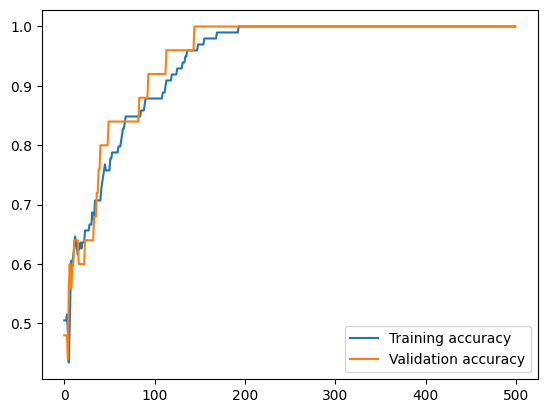

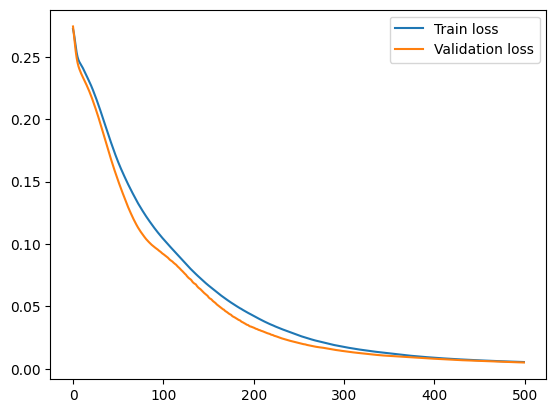

Test MSE: 0.012988336384296417
Test accuracy: 1.0


In [50]:
model = grid_search(params, x_train, y_train, k_fold_val)
test_model(model, x_test, y_test)

# Monk 2

In [57]:
x_train, y_train, x_test, y_test = load_dataset("monks2", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-2 dataset
(169, 17) (169,)
(432, 17) (432,)


In [58]:
params = {
    "task": "classification",
    "trials_train": 1,
    "trials_test": 10,
    "initialization": {
        "type": "default",
        "min": -0.5,
        "max": 0.5
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.0
    },
    "max_epochs": [500],
    "learning_rate": [0.1, 0.2, 0.3],
    "batch_size": [None],
    "momentum": [0.7, 0.8, 0.9],
    "nesterov": False,
    "learning_rate_decay": None,
    "regularization": [
        {
            "type": None
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [8],
        },
    ]
}


params = {
    "task": "classification",
    "trials_train": 1,
    "trials_test": 10,
    "initialization": {
        "type": "default",
        "min": -0.5,
        "max": 0.5
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.0
    },
    "max_epochs": [500],
    "learning_rate": np.linspace(0.1, 0.3, 5).tolist(),
    "batch_size": [None],
    "momentum": np.linspace(0.7, 0.9, 5).tolist(),
    "nesterov": False,
    "learning_rate_decay": None,
    "regularization": [
        {
            "type": None
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [8],
        },
    ]
}


k_fold_val = {
    "type": "k-fold",
    "n_folds": 5
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.15
}

Testing configuration 1/25:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]


Fold 1/5 median val_loss: 0.2883889720557326, std val_loss 0.0
Fold 1/5 median train_loss: 0.2182755023241043, std train_loss 0.0
Fold 1/5 median val_accuracy: 0.4411764740943908, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 0.6666666865348816, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.84s/it]


Fold 2/5 median val_loss: 0.2134631660942645, std val_loss 0.0
Fold 2/5 median train_loss: 0.2242952585220337, std train_loss 0.0
Fold 2/5 median val_accuracy: 0.7058823704719543, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 0.6518518328666687, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.23s/it]


Fold 3/5 median val_loss: 0.0201308207304792, std val_loss 0.0
Fold 3/5 median train_loss: 0.0178703479468822, std train_loss 0.0
Fold 3/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.17it/s]


Fold 4/5 median val_loss: 0.2279225385755967, std val_loss 0.0
Fold 4/5 median train_loss: 0.2314312607049942, std train_loss 0.0
Fold 4/5 median val_accuracy: 0.6764705777168274, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 0.614814817905426, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.00it/s]


Fold 5/5 median val_loss: 0.2499549187823476, std val_loss 0.0
Fold 5/5 median train_loss: 0.2301624119281768, std train_loss 0.0
Fold 5/5 median val_accuracy: 0.5757575631141663, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 0.6323529481887817, train_accuracy 0.0

Mean val_loss: 0.19997208324768412, std val_loss: 0.09340443998844293
Mean train_loss: 0.18440695628523823, std train_loss: 0.08339957303274223
Mean val_accuracy: 0.6798573970794678, std val_accuracy: 0.1849245329418571
Mean train_accuracy: 0.6798573970794678, std train_accuracy: 0.14449848236687635



Testing configuration 2/25:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.75, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'unit

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


Fold 1/5 median val_loss: 0.2551484880402926, std val_loss 0.0
Fold 1/5 median train_loss: 0.2277586460113525, std train_loss 0.0
Fold 1/5 median val_accuracy: 0.5588235259056091, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 0.6370370388031006, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


Fold 2/5 median val_loss: 0.2452280888440945, std val_loss 0.0
Fold 2/5 median train_loss: 0.2325742244720459, std train_loss 0.0
Fold 2/5 median val_accuracy: 0.5882353186607361, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 0.6296296119689941, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]


Fold 3/5 median val_loss: 0.2430994338610241, std val_loss 0.0
Fold 3/5 median train_loss: 0.2304323464632034, std train_loss 0.0
Fold 3/5 median val_accuracy: 0.5882353186607361, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 0.6296296119689941, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.31s/it]


Fold 4/5 median val_loss: 0.0540929572096956, std val_loss 0.0
Fold 4/5 median train_loss: 0.0340236015617847, std train_loss 0.0
Fold 4/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]


Fold 5/5 median val_loss: 0.2159988779073214, std val_loss 0.0
Fold 5/5 median train_loss: 0.2314355969429016, std train_loss 0.0
Fold 5/5 median val_accuracy: 0.7272727489471436, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 0.595588207244873, train_accuracy 0.0

Mean val_loss: 0.20271356917248565, std val_loss: 0.07543541462018509
Mean train_loss: 0.19124488309025764, std train_loss: 0.0786267784825968
Mean val_accuracy: 0.692513382434845, std val_accuracy: 0.16454606677144132
Mean train_accuracy: 0.692513382434845, std train_accuracy: 0.15149717331145737



Testing configuration 3/25:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1'

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.19it/s]


Fold 1/5 median val_loss: 0.2364219781574235, std val_loss 0.0
Fold 1/5 median train_loss: 0.2304879128932953, std train_loss 0.0
Fold 1/5 median val_accuracy: 0.6176470518112183, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 0.6222222447395325, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


Fold 2/5 median val_loss: 0.2515289245784076, std val_loss 0.0
Fold 2/5 median train_loss: 0.2273278385400772, std train_loss 0.0
Fold 2/5 median val_accuracy: 0.5588235259056091, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 0.6370370388031006, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


Fold 3/5 median val_loss: 0.2176310575492836, std val_loss 0.0
Fold 3/5 median train_loss: 0.2362012863159179, std train_loss 0.0
Fold 3/5 median val_accuracy: 0.7058823704719543, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 0.6000000238418579, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.87s/it]


Fold 4/5 median val_loss: 0.0074294763231764, std val_loss 0.0
Fold 4/5 median train_loss: 0.0044893478043377, std train_loss 0.0
Fold 4/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it]


Fold 5/5 median val_loss: 0.2619892496789821, std val_loss 0.0
Fold 5/5 median train_loss: 0.2223658859729766, std train_loss 0.0
Fold 5/5 median val_accuracy: 0.5454545617103577, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 0.6397058963775635, train_accuracy 0.0

Mean val_loss: 0.19500013725745463, std val_loss: 0.09496707353511637
Mean train_loss: 0.18417445430532095, std train_loss: 0.08995472774395608
Mean val_accuracy: 0.6855615019798279, std val_accuracy: 0.1670864139098226
Mean train_accuracy: 0.6855615019798279, std train_accuracy: 0.15076397029705124



Testing configuration 4/25:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.85, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'unit

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.94it/s]


Fold 1/5 median val_loss: 0.2480686450485732, std val_loss 0.0
Fold 1/5 median train_loss: 0.2275198996067047, std train_loss 0.0
Fold 1/5 median val_accuracy: 0.5588235259056091, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 0.6370370388031006, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]


Fold 2/5 median val_loss: 0.2471947113774393, std val_loss 0.0
Fold 2/5 median train_loss: 0.2319509983062744, std train_loss 0.0
Fold 2/5 median val_accuracy: 0.5882353186607361, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 0.6296296119689941, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


Fold 3/5 median val_loss: 0.2569238794444628, std val_loss 0.0
Fold 3/5 median train_loss: 0.2291750013828277, std train_loss 0.0
Fold 3/5 median val_accuracy: 0.5588235259056091, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 0.6370370388031006, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


Fold 4/5 median val_loss: 0.2229534195929653, std val_loss 0.0
Fold 4/5 median train_loss: 0.2277110666036605, std train_loss 0.0
Fold 4/5 median val_accuracy: 0.7058823704719543, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 0.6074073910713196, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


Fold 5/5 median val_loss: 0.2437313909366163, std val_loss 0.0
Fold 5/5 median train_loss: 0.2234436422586441, std train_loss 0.0
Fold 5/5 median val_accuracy: 0.5151515007019043, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 0.6470588445663452, train_accuracy 0.0

Mean val_loss: 0.24377440928001137, std val_loss: 0.011283288128957906
Mean train_loss: 0.22796012163162233, std train_loss: 0.0027588925026859642
Mean val_accuracy: 0.5853832483291626, std val_accuracy: 0.0646088365900068
Mean train_accuracy: 0.5853832483291626, std train_accuracy: 0.013321093334050847



Testing configuration 5/25:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'u

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.20it/s]


Fold 1/5 median val_loss: 0.2336122175066379, std val_loss 0.0
Fold 1/5 median train_loss: 0.225592628121376, std train_loss 0.0
Fold 1/5 median val_accuracy: 0.6176470518112183, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 0.6074073910713196, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s]


Fold 2/5 median val_loss: 0.2559212802833921, std val_loss 0.0
Fold 2/5 median train_loss: 0.2262637615203857, std train_loss 0.0
Fold 2/5 median val_accuracy: 0.5588235259056091, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 0.6370370388031006, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]


Fold 3/5 median val_loss: 0.3098919048748064, std val_loss 0.0
Fold 3/5 median train_loss: 0.2251668870449066, std train_loss 0.0
Fold 3/5 median val_accuracy: 0.4705882370471954, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 0.6592592597007751, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.75s/it]


Fold 4/5 median val_loss: 0.0014304680698783, std val_loss 0.0
Fold 4/5 median train_loss: 0.0011969078332185, std train_loss 0.0
Fold 4/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.52it/s]


Fold 5/5 median val_loss: 0.2142506783147036, std val_loss 0.0
Fold 5/5 median train_loss: 0.2245578318834304, std train_loss 0.0
Fold 5/5 median val_accuracy: 0.6969696879386902, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 0.625, train_accuracy 0.0

Mean val_loss: 0.2030213098098837, std val_loss: 0.10575490607040511
Mean train_loss: 0.18055560328066342, std train_loss: 0.08968107239533184
Mean val_accuracy: 0.6688057005405426, std val_accuracy: 0.18137603099173805
Mean train_accuracy: 0.6688057005405426, std train_accuracy: 0.14809304728580938



Testing configuration 6/25:
{'batch_size': None, 'learning_rate': 0.15, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Exe

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.10it/s]


Fold 1/5 median val_loss: 0.2924585862384738, std val_loss 0.0
Fold 1/5 median train_loss: 0.2203655987977981, std train_loss 0.0
Fold 1/5 median val_accuracy: 0.4411764740943908, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 0.6666666865348816, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


Fold 2/5 median val_loss: 0.245896866787914, std val_loss 0.0
Fold 2/5 median train_loss: 0.2304721921682357, std train_loss 0.0
Fold 2/5 median val_accuracy: 0.5882353186607361, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 0.6296296119689941, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.27s/it]


Fold 3/5 median val_loss: 0.0084567684688809, std val_loss 0.0
Fold 3/5 median train_loss: 0.0064727095887064, std train_loss 0.0
Fold 3/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.31s/it]


Fold 4/5 median val_loss: 0.012416642573099, std val_loss 0.0
Fold 4/5 median train_loss: 0.0111068468540906, std train_loss 0.0
Fold 4/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]


Fold 5/5 median val_loss: 0.2519099228338836, std val_loss 0.0
Fold 5/5 median train_loss: 0.2269436866044998, std train_loss 0.0
Fold 5/5 median val_accuracy: 0.6666666865348816, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 0.6102941036224365, train_accuracy 0.0

Mean val_loss: 0.16222775738045028, std val_loss: 0.12497389055732107
Mean train_loss: 0.13907220680266613, std train_loss: 0.1064347028723508
Mean val_accuracy: 0.7392156958580017, std val_accuracy: 0.22490118600643533
Mean train_accuracy: 0.7392156958580017, std train_accuracy: 0.17946982928774022



Testing configuration 7/25:
{'batch_size': None, 'learning_rate': 0.15, 'max_epochs': 500, 'momentum': 0.75, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'uni

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.60it/s]


Fold 1/5 median val_loss: 0.228104536585712, std val_loss 0.0
Fold 1/5 median train_loss: 0.2272918969392776, std train_loss 0.0
Fold 1/5 median val_accuracy: 0.6176470518112183, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 0.6222222447395325, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]


Fold 2/5 median val_loss: 0.2541476210342754, std val_loss 0.0
Fold 2/5 median train_loss: 0.2296519726514816, std train_loss 0.0
Fold 2/5 median val_accuracy: 0.5588235259056091, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 0.6370370388031006, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


Fold 3/5 median val_loss: 0.2105940247799115, std val_loss 0.0
Fold 3/5 median train_loss: 0.2421470433473587, std train_loss 0.0
Fold 3/5 median val_accuracy: 0.7941176295280457, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 0.5777778029441833, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Fold 4/5 median val_loss: 0.2533657641797982, std val_loss 0.0
Fold 4/5 median train_loss: 0.2294297218322754, std train_loss 0.0
Fold 4/5 median val_accuracy: 0.5588235259056091, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 0.6370370388031006, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.45s/it]


Fold 5/5 median val_loss: 0.0098287077736126, std val_loss 0.0
Fold 5/5 median train_loss: 0.006562705617398, std train_loss 0.0
Fold 5/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.19120813087066196, std val_loss: 0.09215270322786775
Mean train_loss: 0.18701666807755826, std train_loss: 0.09037889270149037
Mean val_accuracy: 0.7058823466300964, std val_accuracy: 0.1704867853702615
Mean train_accuracy: 0.7058823466300964, std train_accuracy: 0.15413103739090062



Testing configuration 8/25:
{'batch_size': None, 'learning_rate': 0.15, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


Fold 1/5 median val_loss: 0.247933202403485, std val_loss 0.0
Fold 1/5 median train_loss: 0.2246590554714203, std train_loss 0.0
Fold 1/5 median val_accuracy: 0.5882353186607361, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 0.6296296119689941, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.63it/s]


Fold 2/5 median val_loss: 0.2390463159986363, std val_loss 0.0
Fold 2/5 median train_loss: 0.2349809855222702, std train_loss 0.0
Fold 2/5 median val_accuracy: 0.6176470518112183, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 0.6222222447395325, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


Fold 3/5 median val_loss: 0.206629583711671, std val_loss 0.0
Fold 3/5 median train_loss: 0.2402743846178054, std train_loss 0.0
Fold 3/5 median val_accuracy: 0.8235294222831726, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 0.5703703761100769, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


Fold 4/5 median val_loss: 0.2843809742567519, std val_loss 0.0
Fold 4/5 median train_loss: 0.2221521884202957, std train_loss 0.0
Fold 4/5 median val_accuracy: 0.4705882370471954, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 0.6592592597007751, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.45s/it]


Fold 5/5 median val_loss: 0.0024470810984809, std val_loss 0.0
Fold 5/5 median train_loss: 0.0027210847474634, std train_loss 0.0
Fold 5/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.196087431493805, std val_loss: 0.09993690178043277
Mean train_loss: 0.184957539755851, std train_loss: 0.09135871740040635
Mean val_accuracy: 0.7000000059604645, std val_accuracy: 0.18823529276996884
Mean train_accuracy: 0.7000000059604645, std train_accuracy: 0.1545292406058487



Testing configuration 9/25:
{'batch_size': None, 'learning_rate': 0.15, 'max_epochs': 500, 'momentum': 0.85, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


Fold 1/5 median val_loss: 0.2306618207726363, std val_loss 0.0
Fold 1/5 median train_loss: 0.2325589656829834, std train_loss 0.0
Fold 1/5 median val_accuracy: 0.6470588445663452, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 0.614814817905426, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


Fold 2/5 median val_loss: 0.2398408615341163, std val_loss 0.0
Fold 2/5 median train_loss: 0.2214771062135696, std train_loss 0.0
Fold 2/5 median val_accuracy: 0.5882353186607361, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 0.6370370388031006, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.35s/it]


Fold 3/5 median val_loss: 0.0027096954716856, std val_loss 0.0
Fold 3/5 median train_loss: 0.0013090858701616, std train_loss 0.0
Fold 3/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


Fold 4/5 median val_loss: 0.296314327646749, std val_loss 0.0
Fold 4/5 median train_loss: 0.2206261456012725, std train_loss 0.0
Fold 4/5 median val_accuracy: 0.4705882370471954, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 0.6592592597007751, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.18s/it]


Fold 5/5 median val_loss: 0.0015099698567997, std val_loss 0.0
Fold 5/5 median train_loss: 0.0012836839305236, std train_loss 0.0
Fold 5/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.1542073350563974, std val_loss: 0.12620681972449632
Mean train_loss: 0.13545099745970215, std train_loss: 0.10961767668150744
Mean val_accuracy: 0.7411764800548554, std val_accuracy: 0.21883617359389737
Mean train_accuracy: 0.7411764800548554, std train_accuracy: 0.17836938506606811



Testing configuration 10/25:
{'batch_size': None, 'learning_rate': 0.15, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/5


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00, 10.00s/it]


Fold 1/5 median val_loss: 0.0021653334694397, std val_loss 0.0
Fold 1/5 median train_loss: 0.0006656235200352, std train_loss 0.0
Fold 1/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


Fold 2/5 median val_loss: 0.2312470803856012, std val_loss 0.0
Fold 2/5 median train_loss: 0.2329253852367401, std train_loss 0.0
Fold 2/5 median val_accuracy: 0.7058823704719543, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 0.6000000238418579, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.90s/it]


Fold 3/5 median val_loss: 0.000573806934234, std val_loss 0.0
Fold 3/5 median train_loss: 0.0006285300478339, std train_loss 0.0
Fold 3/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


Fold 4/5 median val_loss: 0.2665991016008958, std val_loss 0.0
Fold 4/5 median train_loss: 0.2237247228622436, std train_loss 0.0
Fold 4/5 median val_accuracy: 0.5588235259056091, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 0.6370370388031006, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


Fold 5/5 median val_loss: 0.2505908782035734, std val_loss 0.0
Fold 5/5 median train_loss: 0.2238524854183197, std train_loss 0.0
Fold 5/5 median val_accuracy: 0.5454545617103577, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 0.6397058963775635, train_accuracy 0.0

Mean val_loss: 0.15023524011874884, std val_loss: 0.12206388692471552
Mean train_loss: 0.13635934941703448, std train_loss: 0.11085882840165455
Mean val_accuracy: 0.7620320916175842, std val_accuracy: 0.20229176437214114
Mean train_accuracy: 0.7620320916175842, std train_accuracy: 0.18396339701763242



Testing configuration 11/25:
{'batch_size': None, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'uni

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.03it/s]


Fold 1/5 median val_loss: 0.2156474165044928, std val_loss 0.0
Fold 1/5 median train_loss: 0.2346277087926864, std train_loss 0.0
Fold 1/5 median val_accuracy: 0.7058823704719543, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 0.6000000238418579, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.82it/s]


Fold 2/5 median val_loss: 0.2348277264952793, std val_loss 0.0
Fold 2/5 median train_loss: 0.2247858047485351, std train_loss 0.0
Fold 2/5 median val_accuracy: 0.6764705777168274, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 0.6074073910713196, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Fold 3/5 median val_loss: 0.2470215855547567, std val_loss 0.0
Fold 3/5 median train_loss: 0.2301437109708786, std train_loss 0.0
Fold 3/5 median val_accuracy: 0.5882353186607361, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 0.6296296119689941, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]


Fold 4/5 median val_loss: 0.2902954665816579, std val_loss 0.0
Fold 4/5 median train_loss: 0.2148245573043823, std train_loss 0.0
Fold 4/5 median val_accuracy: 0.4411764740943908, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 0.6666666865348816, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.66it/s]


Fold 5/5 median val_loss: 0.2275536937704852, std val_loss 0.0
Fold 5/5 median train_loss: 0.2300819456577301, std train_loss 0.0
Fold 5/5 median val_accuracy: 0.6666666865348816, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 0.6102941036224365, train_accuracy 0.0

Mean val_loss: 0.24306917778133438, std val_loss: 0.025715943054744835
Mean train_loss: 0.22689274549484253, std train_loss: 0.006791903958878493
Mean val_accuracy: 0.6156862854957581, std val_accuracy: 0.0955366893622316
Mean train_accuracy: 0.6156862854957581, std train_accuracy: 0.024017071232325653



Testing configuration 12/25:
{'batch_size': None, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.75, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', '

100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.50s/it]


Fold 1/5 median val_loss: 0.0045701818775941, std val_loss 0.0
Fold 1/5 median train_loss: 0.0030905159655958, std train_loss 0.0
Fold 1/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.46it/s]


Fold 2/5 median val_loss: 0.268062821222043, std val_loss 0.0
Fold 2/5 median train_loss: 0.2241676300764084, std train_loss 0.0
Fold 2/5 median val_accuracy: 0.529411792755127, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 0.644444465637207, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


Fold 3/5 median val_loss: 0.2547063552296007, std val_loss 0.0
Fold 3/5 median train_loss: 0.2249976396560669, std train_loss 0.0
Fold 3/5 median val_accuracy: 0.5588235259056091, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 0.6370370388031006, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.21s/it]


Fold 4/5 median val_loss: 0.0118673066535231, std val_loss 0.0
Fold 4/5 median train_loss: 0.0071501317434012, std train_loss 0.0
Fold 4/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.89s/it]


Fold 5/5 median val_loss: 0.0033350109170583, std val_loss 0.0
Fold 5/5 median train_loss: 0.0028314611408859, std train_loss 0.0
Fold 5/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.10850833517996386, std val_loss: 0.12492842056605981
Mean train_loss: 0.09244747571647163, std train_loss: 0.10789909938290558
Mean val_accuracy: 0.8176470637321472, std val_accuracy: 0.22352940534290536
Mean train_accuracy: 0.8176470637321472, std train_accuracy: 0.17601595582478335



Testing configuration 13/25:
{'batch_size': None, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.98it/s]


Fold 1/5 median val_loss: 0.2490695531394826, std val_loss 0.0
Fold 1/5 median train_loss: 0.2234359979629516, std train_loss 0.0
Fold 1/5 median val_accuracy: 0.6176470518112183, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 0.614814817905426, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Fold 2/5 median val_loss: 0.24701335643492, std val_loss 0.0
Fold 2/5 median train_loss: 0.2237008064985275, std train_loss 0.0
Fold 2/5 median val_accuracy: 0.5882353186607361, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 0.6370370388031006, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]


Fold 3/5 median val_loss: 0.2764148227123186, std val_loss 0.0
Fold 3/5 median train_loss: 0.2221127301454544, std train_loss 0.0
Fold 3/5 median val_accuracy: 0.529411792755127, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 0.644444465637207, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.33s/it]


Fold 4/5 median val_loss: 0.0091414860506723, std val_loss 0.0
Fold 4/5 median train_loss: 0.005115183070302, std train_loss 0.0
Fold 4/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.90s/it]


Fold 5/5 median val_loss: 0.0016531899590451, std val_loss 0.0
Fold 5/5 median train_loss: 0.0012740856036543, std train_loss 0.0
Fold 5/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.15665848165928772, std val_loss: 0.1239623291155158
Mean train_loss: 0.13512776065617796, std train_loss: 0.10773113830147787
Mean val_accuracy: 0.7470588326454163, std val_accuracy: 0.20847111064678706
Mean train_accuracy: 0.7470588326454163, std train_accuracy: 0.18049770752480637



Testing configuration 14/25:
{'batch_size': None, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.85, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/5


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.25s/it]


Fold 1/5 median val_loss: 0.0008338393684911, std val_loss 0.0
Fold 1/5 median train_loss: 0.0010352969402447, std train_loss 0.0
Fold 1/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.97it/s]


Fold 2/5 median val_loss: 0.2202448274085199, std val_loss 0.0
Fold 2/5 median train_loss: 0.2238286286592483, std train_loss 0.0
Fold 2/5 median val_accuracy: 0.6764705777168274, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 0.6000000238418579, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


Fold 3/5 median val_loss: 0.2669938119670399, std val_loss 0.0
Fold 3/5 median train_loss: 0.2274705171585083, std train_loss 0.0
Fold 3/5 median val_accuracy: 0.529411792755127, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 0.644444465637207, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Fold 4/5 median val_loss: 0.2488133175571874, std val_loss 0.0
Fold 4/5 median train_loss: 0.2211171686649322, std train_loss 0.0
Fold 4/5 median val_accuracy: 0.5882353186607361, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 0.6296296119689941, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


Fold 5/5 median val_loss: 0.2533834775519436, std val_loss 0.0
Fold 5/5 median train_loss: 0.2256132364273071, std train_loss 0.0
Fold 5/5 median val_accuracy: 0.5454545617103577, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 0.6397058963775635, train_accuracy 0.0

Mean val_loss: 0.1980538547706364, std val_loss: 0.09977853642901431
Mean train_loss: 0.1798129695700481, std train_loss: 0.08941339678728033
Mean val_accuracy: 0.6679144501686096, std val_accuracy: 0.1737136690736174
Mean train_accuracy: 0.6679144501686096, std train_accuracy: 0.14942275958181006



Testing configuration 15/25:
{'batch_size': None, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


Fold 1/5 median val_loss: 0.2578760792066024, std val_loss 0.0
Fold 1/5 median train_loss: 0.2250917702913284, std train_loss 0.0
Fold 1/5 median val_accuracy: 0.5882353186607361, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 0.6296296119689941, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


Fold 2/5 median val_loss: 0.2348596268661135, std val_loss 0.0
Fold 2/5 median train_loss: 0.2234457582235336, std train_loss 0.0
Fold 2/5 median val_accuracy: 0.6470588445663452, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 0.6370370388031006, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.93s/it]


Fold 3/5 median val_loss: 0.0034878037756694, std val_loss 0.0
Fold 3/5 median train_loss: 0.0013454201398417, std train_loss 0.0
Fold 3/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


Fold 4/5 median val_loss: 0.2719547032619209, std val_loss 0.0
Fold 4/5 median train_loss: 0.2250843495130539, std train_loss 0.0
Fold 4/5 median val_accuracy: 0.529411792755127, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 0.644444465637207, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.22s/it]


Fold 5/5 median val_loss: 0.0004655089249855, std val_loss 0.0
Fold 5/5 median train_loss: 0.0003864620521198, std train_loss 0.0
Fold 5/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.15372874440705833, std val_loss: 0.12447347056607914
Mean train_loss: 0.13507075204397548, std train_loss: 0.10957982983773379
Mean val_accuracy: 0.7529411911964417, std val_accuracy: 0.20512464394023766
Mean train_accuracy: 0.7529411911964417, std train_accuracy: 0.17787651524897352



Testing configuration 16/25:
{'batch_size': None, 'learning_rate': 0.25, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/5

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.17it/s]


Fold 1/5 median val_loss: 0.2322378031837815, std val_loss 0.0
Fold 1/5 median train_loss: 0.2296935468912124, std train_loss 0.0
Fold 1/5 median val_accuracy: 0.6470588445663452, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 0.614814817905426, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.63s/it]


Fold 2/5 median val_loss: 0.0361001796722284, std val_loss 0.0
Fold 2/5 median train_loss: 0.0092949168756604, std train_loss 0.0
Fold 2/5 median val_accuracy: 0.970588207244873, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]


Fold 3/5 median val_loss: 0.2977607413937468, std val_loss 0.0
Fold 3/5 median train_loss: 0.2221879810094833, std train_loss 0.0
Fold 3/5 median val_accuracy: 0.4411764740943908, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 0.6666666865348816, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.86it/s]


Fold 4/5 median val_loss: 0.2261690368384059, std val_loss 0.0
Fold 4/5 median train_loss: 0.2354305386543274, std train_loss 0.0
Fold 4/5 median val_accuracy: 0.6764705777168274, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 0.6074073910713196, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.04s/it]


Fold 5/5 median val_loss: 0.0016906242506929, std val_loss 0.0
Fold 5/5 median train_loss: 0.0015693716704845, std train_loss 0.0
Fold 5/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.1587916770677711, std val_loss: 0.1174567045512026
Mean train_loss: 0.1396352710202336, std train_loss: 0.10968407064136339
Mean val_accuracy: 0.7470588207244873, std val_accuracy: 0.21094612206624658
Mean train_accuracy: 0.7470588207244873, std train_accuracy: 0.18258921197749797



Testing configuration 17/25:
{'batch_size': None, 'learning_rate': 0.25, 'max_epochs': 500, 'momentum': 0.75, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


Fold 1/5 median val_loss: 0.2537213410747975, std val_loss 0.0
Fold 1/5 median train_loss: 0.2211283594369888, std train_loss 0.0
Fold 1/5 median val_accuracy: 0.5588235259056091, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 0.6370370388031006, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.04it/s]


Fold 2/5 median val_loss: 0.2314823826052863, std val_loss 0.0
Fold 2/5 median train_loss: 0.2255387902259826, std train_loss 0.0
Fold 2/5 median val_accuracy: 0.6470588445663452, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 0.6296296119689941, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


Fold 3/5 median val_loss: 0.2502784945441354, std val_loss 0.0
Fold 3/5 median train_loss: 0.2191646695137024, std train_loss 0.0
Fold 3/5 median val_accuracy: 0.6176470518112183, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 0.6296296119689941, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Fold 4/5 median val_loss: 0.231514028854979, std val_loss 0.0
Fold 4/5 median train_loss: 0.2198904156684875, std train_loss 0.0
Fold 4/5 median val_accuracy: 0.6176470518112183, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 0.614814817905426, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.89s/it]


Fold 5/5 median val_loss: 0.0015152859425622, std val_loss 0.0
Fold 5/5 median train_loss: 0.0016181188402697, std train_loss 0.0
Fold 5/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.1937023066043521, std val_loss: 0.0965360667663774
Mean train_loss: 0.1774680707370862, std train_loss: 0.08795280798549707
Mean val_accuracy: 0.6882352948188781, std val_accuracy: 0.15849639584996839
Mean train_accuracy: 0.6882352948188781, std train_accuracy: 0.14906383970085432



Testing configuration 18/25:
{'batch_size': None, 'learning_rate': 0.25, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


Fold 1/5 median val_loss: 0.2291767340432321, std val_loss 0.0
Fold 1/5 median train_loss: 0.225863978266716, std train_loss 0.0
Fold 1/5 median val_accuracy: 0.6470588445663452, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 0.614814817905426, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]


Fold 2/5 median val_loss: 0.263978607012816, std val_loss 0.0
Fold 2/5 median train_loss: 0.2278338074684143, std train_loss 0.0
Fold 2/5 median val_accuracy: 0.529411792755127, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 0.644444465637207, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.05s/it]


Fold 3/5 median val_loss: 0.0009907973365383, std val_loss 0.0
Fold 3/5 median train_loss: 0.0009980614995583, std train_loss 0.0
Fold 3/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.94s/it]


Fold 4/5 median val_loss: 0.001064635661673, std val_loss 0.0
Fold 4/5 median train_loss: 0.0008897646912373, std train_loss 0.0
Fold 4/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


Fold 5/5 median val_loss: 0.2558045495251428, std val_loss 0.0
Fold 5/5 median train_loss: 0.223171129822731, std train_loss 0.0
Fold 5/5 median val_accuracy: 0.5757575631141663, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 0.6323529481887817, train_accuracy 0.0

Mean val_loss: 0.15020306471588044, std val_loss: 0.12234374509810436
Mean train_loss: 0.13575134834973138, std train_loss: 0.11007976980761576
Mean val_accuracy: 0.7504456400871277, std val_accuracy: 0.20717889491644675
Mean train_accuracy: 0.7504456400871277, std train_accuracy: 0.18124404997529656



Testing configuration 19/25:
{'batch_size': None, 'learning_rate': 0.25, 'max_epochs': 500, 'momentum': 0.85, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'un

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.12s/it]


Fold 1/5 median val_loss: 0.0007235414091162, std val_loss 0.0
Fold 1/5 median train_loss: 0.0007371780229732, std train_loss 0.0
Fold 1/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Fold 2/5 median val_loss: 0.2154656076821214, std val_loss 0.0
Fold 2/5 median train_loss: 0.224199429154396, std train_loss 0.0
Fold 2/5 median val_accuracy: 0.7352941036224365, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 0.6296296119689941, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.40it/s]


Fold 3/5 median val_loss: 0.2313950798212998, std val_loss 0.0
Fold 3/5 median train_loss: 0.2156613618135452, std train_loss 0.0
Fold 3/5 median val_accuracy: 0.6764705777168274, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 0.644444465637207, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


Fold 4/5 median val_loss: 0.2551324129689946, std val_loss 0.0
Fold 4/5 median train_loss: 0.2146759182214737, std train_loss 0.0
Fold 4/5 median val_accuracy: 0.5588235259056091, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 0.6592592597007751, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


Fold 5/5 median val_loss: 0.2666954588677215, std val_loss 0.0
Fold 5/5 median train_loss: 0.2237244397401809, std train_loss 0.0
Fold 5/5 median val_accuracy: 0.5151515007019043, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 0.6470588445663452, train_accuracy 0.0

Mean val_loss: 0.19388242014985071, std val_loss: 0.09822085958057203
Mean train_loss: 0.17579966539051378, std train_loss: 0.0876202185435246
Mean val_accuracy: 0.6971479415893554, std val_accuracy: 0.17079719014555528
Mean train_accuracy: 0.6971479415893554, std train_accuracy: 0.14227325974158211



Testing configuration 20/25:
{'batch_size': None, 'learning_rate': 0.25, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'uni

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.84s/it]


Fold 1/5 median val_loss: 0.0004123869097758, std val_loss 0.0
Fold 1/5 median train_loss: 0.0003146164526697, std train_loss 0.0
Fold 1/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


Fold 2/5 median val_loss: 0.2416795924930914, std val_loss 0.0
Fold 2/5 median train_loss: 0.1957365274429321, std train_loss 0.0
Fold 2/5 median val_accuracy: 0.6176470518112183, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 0.7185184955596924, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.34s/it]


Fold 3/5 median val_loss: 0.0005429296190602, std val_loss 0.0
Fold 3/5 median train_loss: 0.0005006607971154, std train_loss 0.0
Fold 3/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


Fold 4/5 median val_loss: 0.2442005837743709, std val_loss 0.0
Fold 4/5 median train_loss: 0.2184182852506637, std train_loss 0.0
Fold 4/5 median val_accuracy: 0.5882353186607361, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 0.6296296119689941, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.16it/s]


Fold 5/5 median val_loss: 0.2624265524185452, std val_loss 0.0
Fold 5/5 median train_loss: 0.2195856720209121, std train_loss 0.0
Fold 5/5 median val_accuracy: 0.5454545617103577, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 0.6323529481887817, train_accuracy 0.0

Mean val_loss: 0.1498524090429687, std val_loss: 0.12217396474968166
Mean train_loss: 0.1269111523928586, std train_loss: 0.10363913305355535
Mean val_accuracy: 0.7502673864364624, std val_accuracy: 0.2051943439135815
Mean train_accuracy: 0.7502673864364624, std train_accuracy: 0.16952568943912777



Testing configuration 21/25:
{'batch_size': None, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.21s/it]


Fold 1/5 median val_loss: 0.2481661684885929, std val_loss 0.0
Fold 1/5 median train_loss: 0.1882844716310501, std train_loss 0.0
Fold 1/5 median val_accuracy: 0.6176470518112183, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 0.7259259223937988, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]


Fold 2/5 median val_loss: 0.2228205056444333, std val_loss 0.0
Fold 2/5 median train_loss: 0.2204308211803436, std train_loss 0.0
Fold 2/5 median val_accuracy: 0.6764705777168274, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 0.6592592597007751, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.81it/s]


Fold 3/5 median val_loss: 0.2405911615761224, std val_loss 0.0
Fold 3/5 median train_loss: 0.2260978519916534, std train_loss 0.0
Fold 3/5 median val_accuracy: 0.6176470518112183, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 0.6222222447395325, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.44s/it]


Fold 4/5 median val_loss: 0.0023194878470113, std val_loss 0.0
Fold 4/5 median train_loss: 0.0026892803143709, std train_loss 0.0
Fold 4/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


Fold 5/5 median val_loss: 0.2420643347162339, std val_loss 0.0
Fold 5/5 median train_loss: 0.2197049707174301, std train_loss 0.0
Fold 5/5 median val_accuracy: 0.6060606241226196, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 0.6691176295280457, train_accuracy 0.0

Mean val_loss: 0.19119233165447874, std val_loss: 0.09481299034900417
Mean train_loss: 0.17144147916696964, std train_loss: 0.08541385174622161
Mean val_accuracy: 0.7035650610923767, std val_accuracy: 0.15025225981729395
Mean train_accuracy: 0.7035650610923767, std train_accuracy: 0.13645720375758122



Testing configuration 22/25:
{'batch_size': None, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.75, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'un

100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.35s/it]


Fold 1/5 median val_loss: 0.0047323835526713, std val_loss 0.0
Fold 1/5 median train_loss: 0.0028973701409995, std train_loss 0.0
Fold 1/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


Fold 2/5 median val_loss: 0.2308132934456897, std val_loss 0.0
Fold 2/5 median train_loss: 0.2222452908754348, std train_loss 0.0
Fold 2/5 median val_accuracy: 0.6764705777168274, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 0.6000000238418579, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Fold 3/5 median val_loss: 0.2533249814771472, std val_loss 0.0
Fold 3/5 median train_loss: 0.2269249707460403, std train_loss 0.0
Fold 3/5 median val_accuracy: 0.5588235259056091, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 0.6370370388031006, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.80s/it]


Fold 4/5 median val_loss: 0.0012636302922985, std val_loss 0.0
Fold 4/5 median train_loss: 0.0009777130326256, std train_loss 0.0
Fold 4/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


Fold 5/5 median val_loss: 0.2555120573235853, std val_loss 0.0
Fold 5/5 median train_loss: 0.2213211804628372, std train_loss 0.0
Fold 5/5 median val_accuracy: 0.5151515007019043, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 0.6470588445663452, train_accuracy 0.0

Mean val_loss: 0.1491292692182784, std val_loss: 0.1196336337633281
Mean train_loss: 0.13487330505158748, std train_loss: 0.10855992371467187
Mean val_accuracy: 0.7500891208648681, std val_accuracy: 0.21076470202497632
Mean train_accuracy: 0.7500891208648681, std train_accuracy: 0.1828995147427498



Testing configuration 23/25:
{'batch_size': None, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_

100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.41s/it]


Fold 1/5 median val_loss: 0.0008899779447152, std val_loss 0.0
Fold 1/5 median train_loss: 0.0007108068093657, std train_loss 0.0
Fold 1/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Fold 2/5 median val_loss: 0.2577480604413721, std val_loss 0.0
Fold 2/5 median train_loss: 0.2226864844560623, std train_loss 0.0
Fold 2/5 median val_accuracy: 0.5588235259056091, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 0.6370370388031006, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.45s/it]


Fold 3/5 median val_loss: 0.0013678909668419, std val_loss 0.0
Fold 3/5 median train_loss: 0.0007192660705186, std train_loss 0.0
Fold 3/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.07s/it]


Fold 4/5 median val_loss: 0.0074886074621608, std val_loss 0.0
Fold 4/5 median train_loss: 0.0020998627878725, std train_loss 0.0
Fold 4/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.33s/it]


Fold 5/5 median val_loss: 0.0043343336758432, std val_loss 0.0
Fold 5/5 median train_loss: 0.0021826247684657, std train_loss 0.0
Fold 5/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.05436577409818664, std val_loss: 0.10171863602249986
Mean train_loss: 0.04567980897845696, std train_loss: 0.08850563991347302
Mean val_accuracy: 0.9117647051811218, std val_accuracy: 0.17647058963775633
Mean train_accuracy: 0.9117647051811218, std train_accuracy: 0.14518518447875978



Testing configuration 24/25:
{'batch_size': None, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.85, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/5

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


Fold 1/5 median val_loss: 0.2345493182365604, std val_loss 0.0
Fold 1/5 median train_loss: 0.2086017727851867, std train_loss 0.0
Fold 1/5 median val_accuracy: 0.6470588445663452, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 0.6814814805984497, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


Fold 2/5 median val_loss: 0.2442507249550959, std val_loss 0.0
Fold 2/5 median train_loss: 0.2263768762350082, std train_loss 0.0
Fold 2/5 median val_accuracy: 0.5882353186607361, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 0.6296296119689941, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]


Fold 3/5 median val_loss: 0.2580648477916984, std val_loss 0.0
Fold 3/5 median train_loss: 0.2220123410224914, std train_loss 0.0
Fold 3/5 median val_accuracy: 0.5588235259056091, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 0.6370370388031006, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.88s/it]


Fold 4/5 median val_loss: 0.0005591253492542, std val_loss 0.0
Fold 4/5 median train_loss: 0.0004441438941285, std train_loss 0.0
Fold 4/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.49s/it]


Fold 5/5 median val_loss: 0.0008628505003726, std val_loss 0.0
Fold 5/5 median train_loss: 0.0006863638409413, std train_loss 0.0
Fold 5/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.1476573733665963, std val_loss: 0.12021382830324281
Mean train_loss: 0.13162429955555122, std train_loss: 0.10716954461133381
Mean val_accuracy: 0.7588235378265381, std val_accuracy: 0.19895922384201797
Mean train_accuracy: 0.7588235378265381, std train_accuracy: 0.1726800000144545



Testing configuration 25/25:
{'batch_size': None, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Fold 1/5 median val_loss: 0.2515082651817035, std val_loss 0.0
Fold 1/5 median train_loss: 0.2137692868709564, std train_loss 0.0
Fold 1/5 median val_accuracy: 0.5882353186607361, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 0.6518518328666687, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Fold 2/5 median val_loss: 0.2545006625362864, std val_loss 0.0
Fold 2/5 median train_loss: 0.2164998650550842, std train_loss 0.0
Fold 2/5 median val_accuracy: 0.529411792755127, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 0.644444465637207, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.86it/s]


Fold 3/5 median val_loss: 0.2164429146314824, std val_loss 0.0
Fold 3/5 median train_loss: 0.2235704064369201, std train_loss 0.0
Fold 3/5 median val_accuracy: 0.7352941036224365, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 0.6888889074325562, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.43s/it]


Fold 4/5 median val_loss: 0.0004342444642443, std val_loss 0.0
Fold 4/5 median train_loss: 0.0002661374455783, std train_loss 0.0
Fold 4/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.13s/it]


Fold 5/5 median val_loss: 0.000339864061355, std val_loss 0.0
Fold 5/5 median train_loss: 0.0002577253326307, std train_loss 0.0
Fold 5/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.14464519017501434, std val_loss: 0.11854423550075695
Mean train_loss: 0.13087268422823395, std train_loss: 0.1066912049594796
Mean val_accuracy: 0.7705882430076599, std val_accuracy: 0.19895921890772292
Mean train_accuracy: 0.7705882430076599, std train_accuracy: 0.16640143206280494






Best configuration (loss 0.05436577409818664):
{'batch_size': None, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}


 10%|████▍                                       | 1/10 [00:00<00:04,  2.23it/s]

Trial 1/10 val_mse: 0.2350797955992349
Trial 1/10 train_mse: 0.2095061689615249
Trial 1/10 val_accuracy: 0.5882353186607361
Trial 1/10 train_accuracy: 0.6814814805984497


 20%|████████▊                                   | 2/10 [00:09<00:41,  5.21s/it]

Trial 2/10 val_mse: 0.0008403239215046
Trial 2/10 train_mse: 0.0006119076278991
Trial 2/10 val_accuracy: 1.0
Trial 2/10 train_accuracy: 1.0


 30%|█████████████▏                              | 3/10 [00:09<00:21,  3.01s/it]

Trial 3/10 val_mse: 0.233765650491442
Trial 3/10 train_mse: 0.2161069214344024
Trial 3/10 val_accuracy: 0.6176470518112183
Trial 3/10 train_accuracy: 0.6296296119689941


 40%|█████████████████▌                          | 4/10 [00:17<00:30,  5.04s/it]

Trial 4/10 val_mse: 0.0009348951912622
Trial 4/10 train_mse: 0.0006553317653015
Trial 4/10 val_accuracy: 1.0
Trial 4/10 train_accuracy: 1.0


 50%|██████████████████████                      | 5/10 [00:25<00:31,  6.22s/it]

Trial 5/10 val_mse: 0.0014162820290412
Trial 5/10 train_mse: 0.0007512138690799
Trial 5/10 val_accuracy: 1.0
Trial 5/10 train_accuracy: 1.0


 60%|██████████████████████████▍                 | 6/10 [00:33<00:27,  6.83s/it]

Trial 6/10 val_mse: 0.0009973429825755
Trial 6/10 train_mse: 0.0006454969989135
Trial 6/10 val_accuracy: 1.0
Trial 6/10 train_accuracy: 1.0


 70%|██████████████████████████████▊             | 7/10 [00:42<00:22,  7.39s/it]

Trial 7/10 val_mse: 0.0009166031783412
Trial 7/10 train_mse: 0.000649168563541
Trial 7/10 val_accuracy: 1.0
Trial 7/10 train_accuracy: 1.0


 80%|███████████████████████████████████▏        | 8/10 [00:51<00:15,  7.78s/it]

Trial 8/10 val_mse: 0.001074197244847
Trial 8/10 train_mse: 0.000676401425153
Trial 8/10 val_accuracy: 1.0
Trial 8/10 train_accuracy: 1.0


 90%|███████████████████████████████████████▌    | 9/10 [00:51<00:05,  5.50s/it]

Trial 9/10 val_mse: 0.2385548145871437
Trial 9/10 train_mse: 0.2273688465356826
Trial 9/10 val_accuracy: 0.6176470518112183
Trial 9/10 train_accuracy: 0.6222222447395325


100%|███████████████████████████████████████████| 10/10 [01:00<00:00,  6.03s/it]

Trial 10/10 val_mse: 0.0009867594057944
Trial 10/10 train_mse: 0.0006803916767239
Trial 10/10 val_accuracy: 1.0
Trial 10/10 train_accuracy: 1.0

Median val_mse: 0.001074197244847, std val_mse: 0.10759381295758244
Median train_mse: 0.000676401425153, std train_mse: 0.09952093248154331
Median val_accuracy: 1.0, std val_accuracy: 0.17986923159684523
Median train_accuracy: 1.0, std train_accuracy: 0.16357460896226042


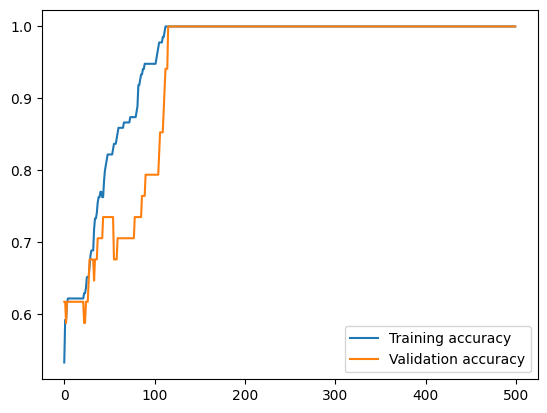

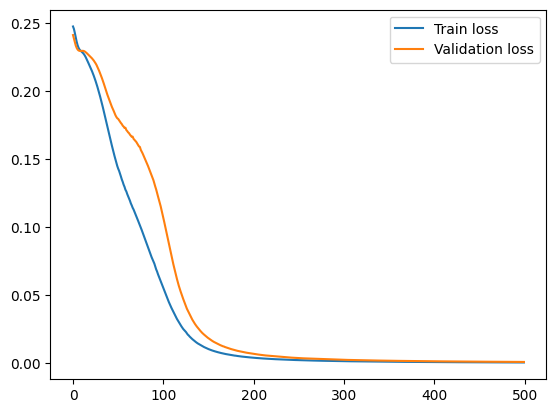

Test MSE: 0.0009809647453948855
Test accuracy: 1.0


In [59]:
model = grid_search(params, x_train, y_train, k_fold_val)
test_model(model, x_test, y_test)

# Monk 3

In [63]:
x_train, y_train, x_test, y_test = load_dataset("monks3", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-3 dataset
(122, 17) (122,)
(432, 17) (432,)


In [71]:
params = {
    "task": "classification",
    "trials_train": 1,
    "trials_test": 10,
    "initialization": {
        "type": "default",
        "min": -0.5,
        "max": 0.5
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.0
    },
    "max_epochs": [500],
    "learning_rate": np.linspace(0.3, 0.7, 3).tolist(),
    "batch_size": [None],
    "momentum": np.linspace(0.6, 0.9, 3).tolist(),
    "nesterov": False,
    "learning_rate_decay": None,
    "regularization": [
        {
            "type": "l2",
            "value": [0.0001]
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [16],
        },
    ]
}

k_fold_val = {
    "type": "k-fold",
    "n_folds": 5
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.2
}


Testing configuration 1/1:
{'batch_size': 16, 'learning_rate': 0.05, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.1, 'max': 0.1}, 'early_stopping': {'monitor': 'val_loss', 'patience': 10, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_test': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.001}, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 100}

Executing fold 1/5


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.41s/it]


Fold 1/5 median val_loss: 0.0067614717409014, std val_loss 0.0
Fold 1/5 median train_loss: 0.0114761563017964, std train_loss 0.0
Fold 1/5 median val_mee: 0.096649669110775, std val_mee 0.0
Fold 1/5 median train_mee: 0.0959205776453018, train_mee 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.93s/it]


Fold 2/5 median val_loss: 0.0056829405948519, std val_loss 0.0
Fold 2/5 median train_loss: 0.0117598762735724, std train_loss 0.0
Fold 2/5 median val_mee: 0.0888475701212883, std val_mee 0.0
Fold 2/5 median train_mee: 0.0965029895305633, train_mee 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.67s/it]


Fold 3/5 median val_loss: 0.007325030863285, std val_loss 0.0
Fold 3/5 median train_loss: 0.0114032421261072, std train_loss 0.0
Fold 3/5 median val_mee: 0.100348025560379, std val_mee 0.0
Fold 3/5 median train_mee: 0.094821386039257, train_mee 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.63s/it]


Fold 4/5 median val_loss: 0.0069949114695191, std val_loss 0.0
Fold 4/5 median train_loss: 0.0116865914314985, std train_loss 0.0
Fold 4/5 median val_mee: 0.0976495295763015, std val_mee 0.0
Fold 4/5 median train_mee: 0.0962502136826515, train_mee 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.58s/it]


Fold 5/5 median val_loss: 0.0059514590539038, std val_loss 0.0
Fold 5/5 median train_loss: 0.011737453751266, std train_loss 0.0
Fold 5/5 median val_mee: 0.0905270501971244, std val_mee 0.0
Fold 5/5 median train_mee: 0.0968455746769905, train_mee 0.0

Mean val_loss: 0.0065431627444922395, std val_loss: 0.0006250038220441415
Mean train_loss: 0.011612663976848101, std train_loss: 0.00014505245504503852
Mean val_mee: 0.09480436891317365, std val_mee: 0.004382033963493522
Mean train_mee: 0.09480436891317365, std train_mee: 0.0006932271927643166






Best configuration (loss 0.0065431627444922395):
{'batch_size': 16, 'learning_rate': 0.05, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.1, 'max': 0.1}, 'early_stopping': {'monitor': 'val_loss', 'patience': 10, 'delta': 0.01}, 'task': 'regression', 'trials_train': 1, 'trials_test': 5, 'nesterov': False, 'learning_rate_decay': {'epochs': 100, 'lr_final': 0.001}, 'regularization': {'method': 'l1', 'value': 0

 20%|█████████                                    | 1/5 [00:02<00:10,  2.58s/it]

Trial 1/5 val_mse: 0.0070279776118695
Trial 1/5 train_mse: 0.0116356639191508
Trial 1/5 val_mee: 0.0971260368824005
Trial 1/5 train_mee: 0.0976147577166557


 40%|██████████████████                           | 2/5 [00:05<00:07,  2.58s/it]

Trial 2/5 val_mse: 0.0069869994185864
Trial 2/5 train_mse: 0.0117866285145282
Trial 2/5 val_mee: 0.0963224917650222
Trial 2/5 train_mee: 0.0980324149131774


 60%|███████████████████████████                  | 3/5 [00:08<00:05,  2.72s/it]

Trial 3/5 val_mse: 0.006962536368519
Trial 3/5 train_mse: 0.0117912730202078
Trial 3/5 val_mee: 0.0962832644581794
Trial 3/5 train_mee: 0.0980078279972076


 80%|████████████████████████████████████         | 4/5 [00:10<00:02,  2.72s/it]

Trial 4/5 val_mse: 0.0070291222073137
Trial 4/5 train_mse: 0.011940311640501
Trial 4/5 val_mee: 0.0959836021065712
Trial 4/5 train_mee: 0.0976365357637405


100%|█████████████████████████████████████████████| 5/5 [00:13<00:00,  2.72s/it]

Trial 5/5 val_mse: 0.0070163151249289
Trial 5/5 train_mse: 0.0118353245779871
Trial 5/5 val_mee: 0.095317505300045
Trial 5/5 train_mee: 0.0969056859612464

Median val_mse: 0.0070163151249289, std val_mse: 2.5939254477877095e-05
Median train_mse: 0.0118353245779871, std train_mse: 9.815616716543044e-05
Median val_mee: 0.095317505300045, std val_mee: 0.0005839332093738875
Median train_mee: 0.0969056859612464, std train_mee: 0.00040722270021698254


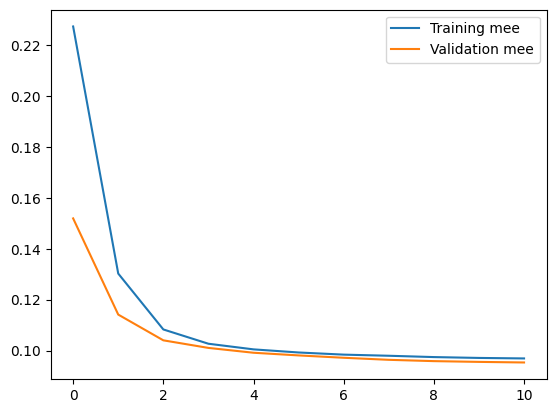

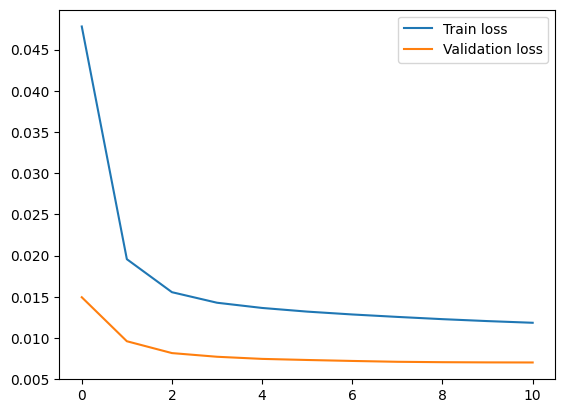


Validation MSE: 5.459822177886963
Validation MEE: 1.9134626388549805
Test MSE: 0.008921989239752293
Test accuracy: 0.1093350201845169


In [23]:
model = grid_search(params, x_train, y_train, k_fold_val)
test_model(model, x_test, y_test)